In [1]:
import numpy as np
np.random.seed(1)

# grAdapt
import grAdapt
from grAdapt.space.datatype import Float, Integer
from grAdapt.optimizer import AMSGrad, Adam, AMSGradBisection
from grAdapt.surrogate import GPRSlidingWindow, NoModel, NoGradient
from grAdapt.models import Sequential

# sklearn
# Import datasets, classifiers and performance metrics
from sklearn.metrics import log_loss
from sklearn import datasets, svm, metrics
from sklearn.model_selection import train_test_split

# scipy bfgs
import scipy

# The digits dataset
digits = datasets.load_digits()

# plot
import matplotlib.pyplot as plt

## 1. Load NIST Dataset

In [2]:
import os
plot_path = 'plots/'
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

In [3]:
# The digits dataset
digits = datasets.load_digits()

# To apply a classifier on this data, we need to flatten the image, to
# turn the data in a (samples, feature) matrix:
n_samples = len(digits.images)
data = digits.images.reshape((n_samples, -1))

## 2. Fit SVM

In [4]:
# Create a classifier: a support vector classifier
classifier = svm.SVC(gamma=0.001, probability=True)

# Split data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(
    data, digits.target, test_size=0.5, shuffle=False)

# We learn the digits on the first half of the digits
classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [5]:
classifier.score(X_test, y_test)

0.9688542825361512

In [6]:
X_train.shape

(898, 64)

## 3. Define Black-Box

In [7]:
def categorical_similarity(x1, x2):
    if x1 == x2:
        return 1
    else:
        return 0

In [8]:
def adversarial_examples_target_idx(perturbation, target_idx):
    perturbation_tmp = np.round(np.array(perturbation, dtype=np.float))
    perturbed_image = (X_test[target_idx] + perturbation_tmp).reshape(1, -1)
    pred_label_perturbed = classifier.predict(perturbed_image)[0]
    pred_label = classifier.predict(X_test[target_idx].reshape(1, -1))[0]
    
    # distance for categorical attributes
    categorical_loss = categorical_similarity(pred_label_perturbed, pred_label)
    # minimal perturbation
    perturbation_loss = np.linalg.norm(perturbation)/len(perturbation)
    
    return categorical_loss + perturbation_loss

In [9]:
def find_n_examples_grAdapt(n):
    ress = []
    for i in range(n):
        target_idx = i
        adversarial_examples = lambda x: adversarial_examples_target_idx(x, target_idx)
        upper_bounds = (16*np.ones(X_test[target_idx].shape[0]) - X_test[target_idx])
        bounds = [Integer(0, x) for x in upper_bounds]
        
        surrogate = NoGradient()
        model = Sequential(surrogate=surrogate)
        res = model.minimize(adversarial_examples, bounds, 1000, show_progressbar=False)
        
        ress.append(res)
        print('Step: {}'.format(i))
    return ress

In [10]:
def find_n_examples_bfgs(n):
    ress = []
    for i in range(n):
        target_idx = i
        adversarial_examples = lambda x: adversarial_examples_target_idx(x, target_idx)
        upper_bounds = (16*np.ones(X_test[target_idx].shape[0]) - X_test[target_idx])
        bounds = [Float(0, x) for x in upper_bounds]
        
        x0 = grAdapt.utils.sampling.sample_points_bounds(bounds, 1, random_state=1)
        res_scipy = scipy.optimize.minimize(adversarial_examples, x0, bounds=bounds)
        
        ress.append(res_scipy)
        print('Step: {}'.format(i))
    return ress

In [11]:
n_images = 100

In [12]:
ress_bfgs = find_n_examples_bfgs(n_images)

Step: 0
Step: 1
Step: 2
Step: 3
Step: 4
Step: 5
Step: 6
Step: 7
Step: 8
Step: 9
Step: 10
Step: 11
Step: 12
Step: 13
Step: 14
Step: 15
Step: 16
Step: 17
Step: 18
Step: 19
Step: 20
Step: 21
Step: 22
Step: 23
Step: 24
Step: 25
Step: 26
Step: 27
Step: 28
Step: 29
Step: 30
Step: 31
Step: 32
Step: 33
Step: 34
Step: 35
Step: 36
Step: 37
Step: 38
Step: 39
Step: 40
Step: 41
Step: 42
Step: 43
Step: 44
Step: 45
Step: 46
Step: 47
Step: 48
Step: 49
Step: 50
Step: 51
Step: 52
Step: 53
Step: 54
Step: 55
Step: 56
Step: 57
Step: 58
Step: 59
Step: 60
Step: 61
Step: 62
Step: 63
Step: 64
Step: 65
Step: 66
Step: 67
Step: 68
Step: 69
Step: 70
Step: 71
Step: 72
Step: 73
Step: 74
Step: 75
Step: 76
Step: 77
Step: 78
Step: 79
Step: 80
Step: 81
Step: 82
Step: 83
Step: 84
Step: 85
Step: 86
Step: 87
Step: 88
Step: 89
Step: 90
Step: 91
Step: 92
Step: 93
Step: 94
Step: 95
Step: 96
Step: 97
Step: 98
Step: 99


In [13]:
ress_grAdapt = find_n_examples_grAdapt(n_images)

  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 0
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 1
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 2
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 3
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 4
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 5
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 6
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 7
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 8
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...
Step: 9
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 10
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 11
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 12
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 13
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...
Step: 14
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...
Step: 15
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 16
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 17
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...
Step: 18
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 19
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 20
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 21
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 22
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 23
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 24
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 25
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 26
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 27
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 28
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 29
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 30
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 31
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 32
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 33
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 34
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 35
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 36
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 37
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 38
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 39
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 40
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 41
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 42
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 43
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 44
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 45
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 46
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 47
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 48
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 49
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 50
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 51
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 52
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 53
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 54
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 55
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 56
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 57
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 58
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 59
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 60
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 61
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 62
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 63
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 64
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 65
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 66
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...
Step: 67
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 68
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 69
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 70
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 71
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 72
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...
Step: 73
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 74
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 75
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 76
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 77
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 78
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 79
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 80
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 81
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 82
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 83
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 84
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 85
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 86
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 87
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 88
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 89
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 90
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 91
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 92
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 93
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 94
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 95
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 96
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 97
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...


  0%|                                                                                         | 0/1000 [00:00<?, ?it/s]

Step: 98
Sampling 488 random points.
Random function evaluations. This might take a while.


Finding optimum...
Step: 99


## 4. grAdapt Outputs

### 4.1 Plots

In [14]:
def plot_grAdapt_original_perturbed(target_idx, ress):
    fig=plt.figure(figsize=(8, 8))
    columns = 2
    rows = 1
    perturbed_image = np.array(ress[target_idx]['x_sol'] + X_test[target_idx], dtype=np.float)
    img = [X_test[target_idx], perturbed_image]
    original_label = classifier.predict(X_test[target_idx].reshape(1, -1))[0]
    perturbed_label = classifier.predict(perturbed_image.reshape(1, -1))[0]
    labels = ['Original label: '+str(original_label), 'Perturbed label: '+str(perturbed_label)]
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i, title=labels[i-1]+str())
        plt.imshow(img[i-1].reshape(8, 8), cmap=plt.cm.binary)
        plt.xticks([], [])
        plt.yticks([], [])
        
    plot_filepath = plot_path+'grAdapt_'+str(target_idx)+'.pdf'
    plt.savefig(plot_filepath, bbox_inches='tight')
    plt.show()

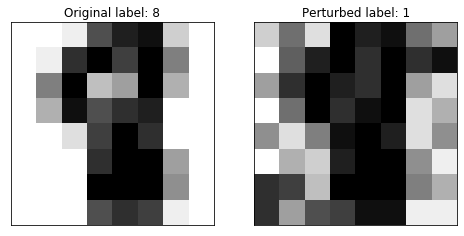

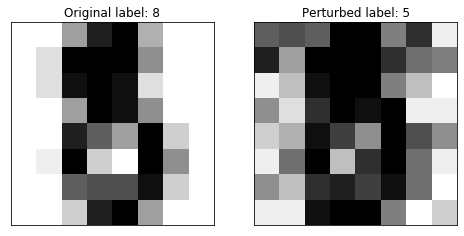

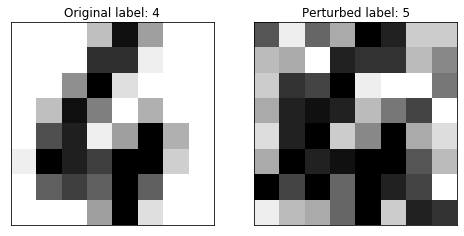

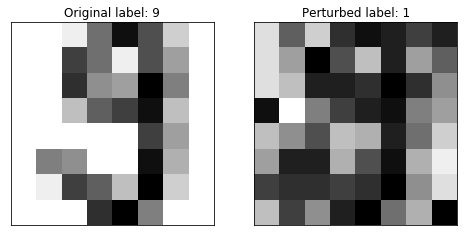

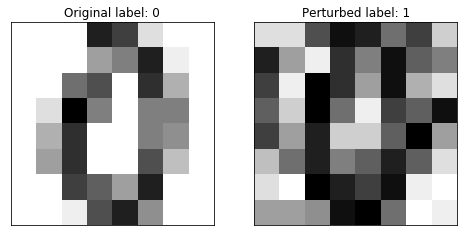

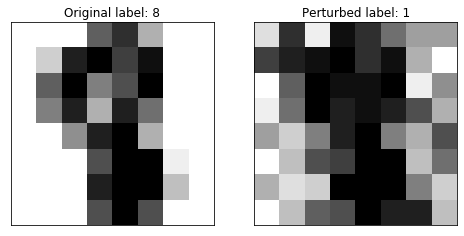

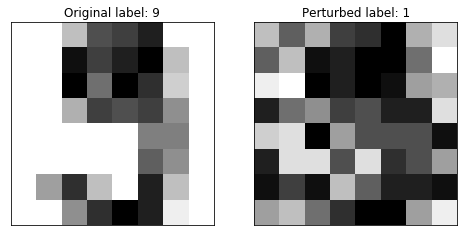

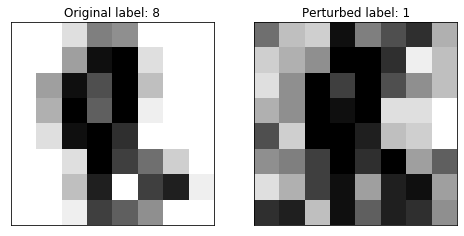

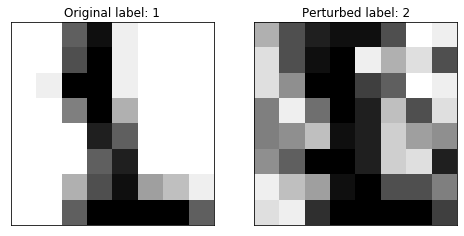

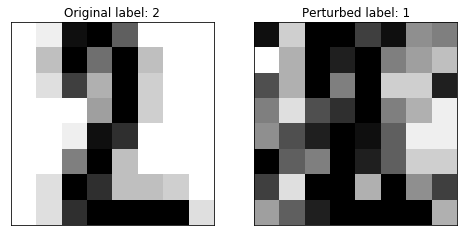

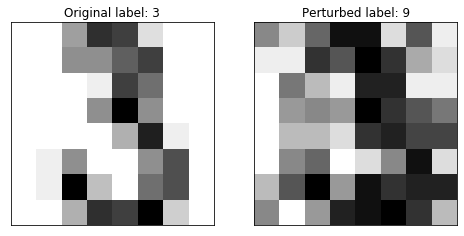

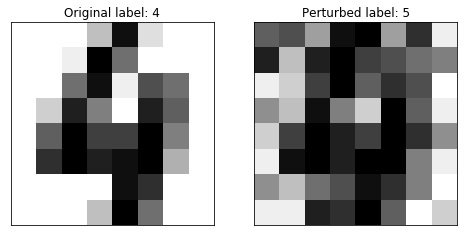

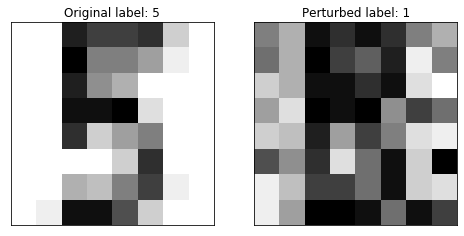

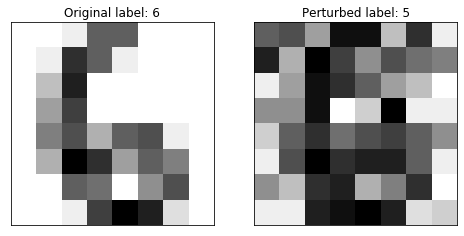

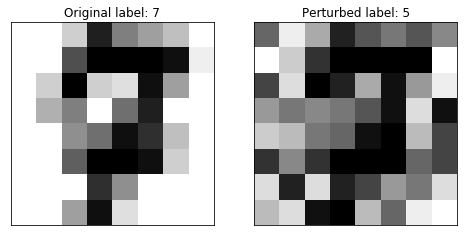

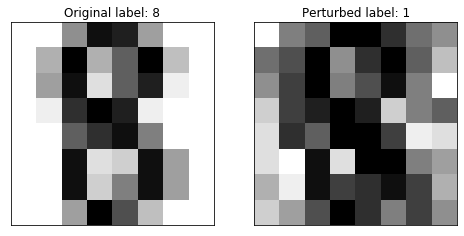

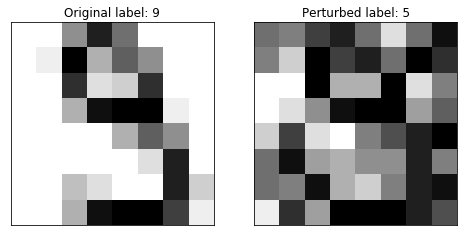

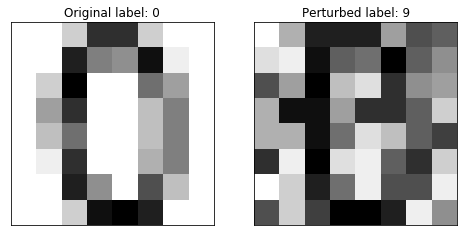

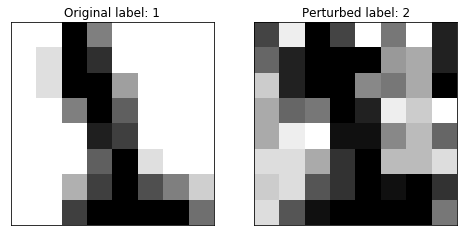

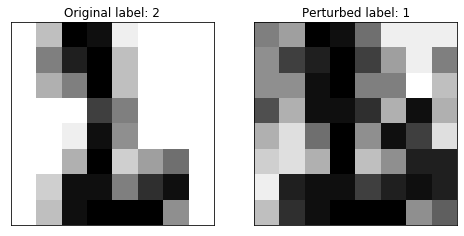

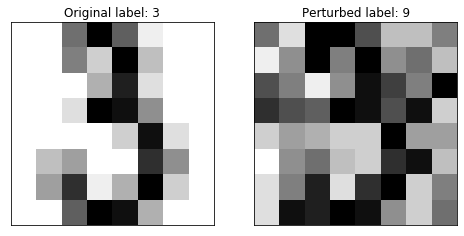

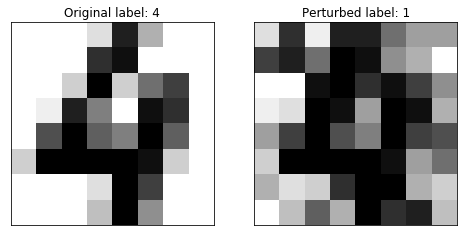

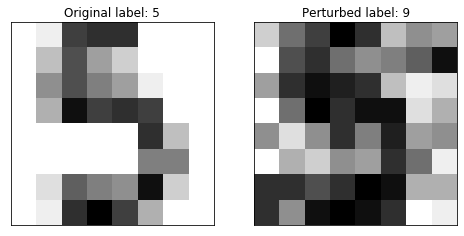

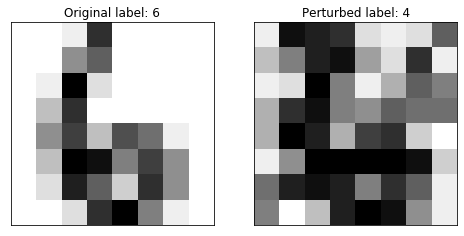

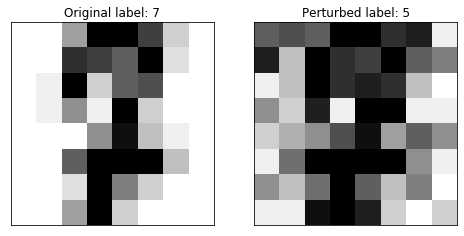

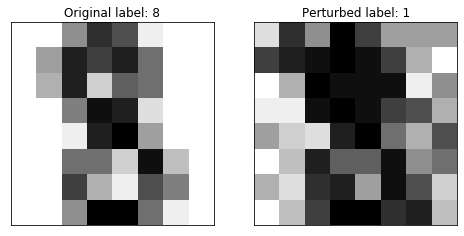

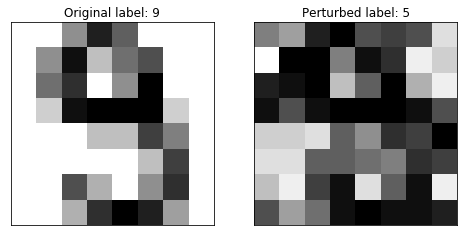

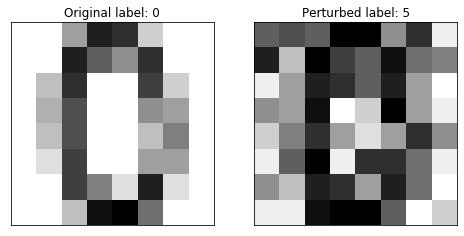

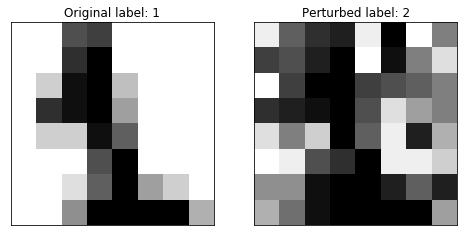

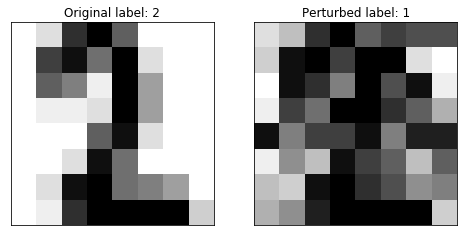

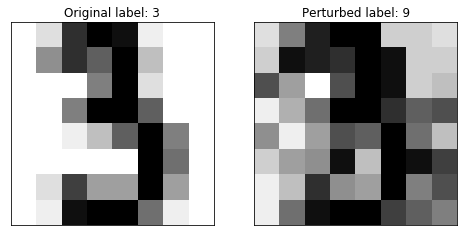

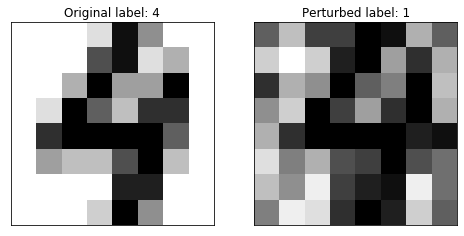

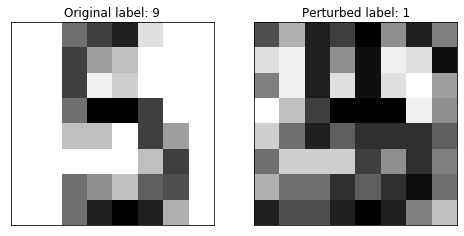

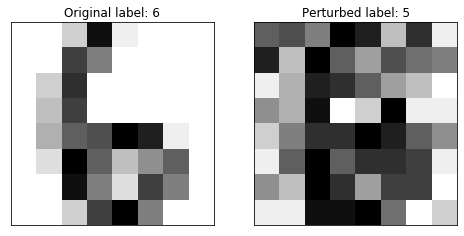

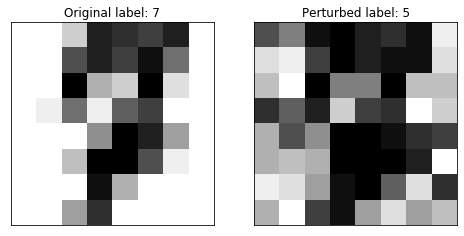

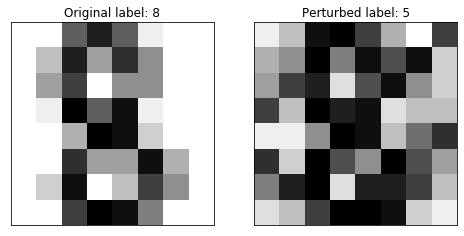

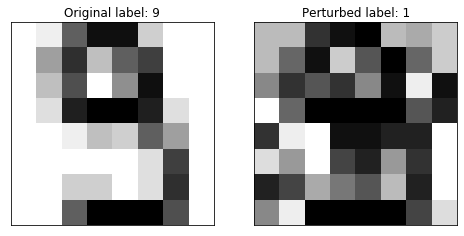

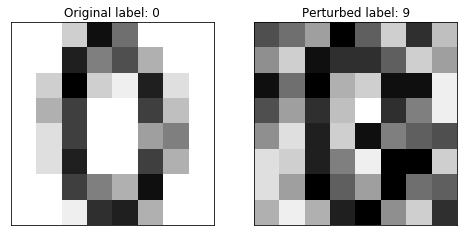

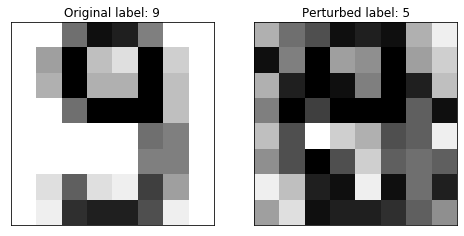

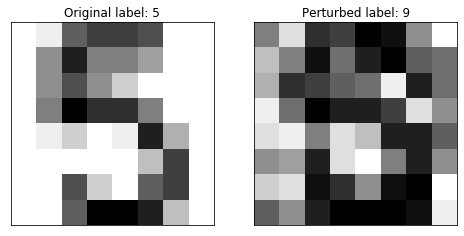

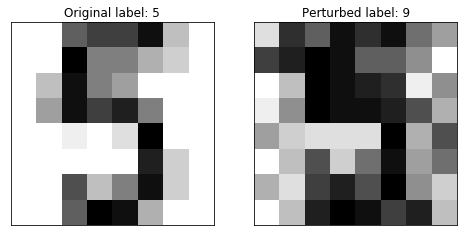

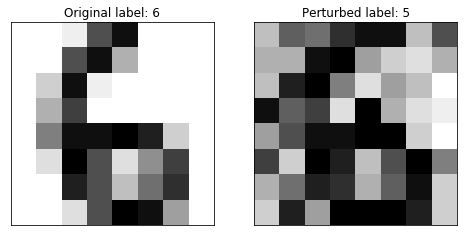

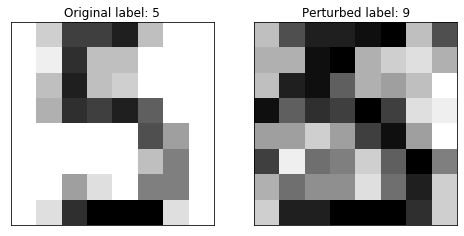

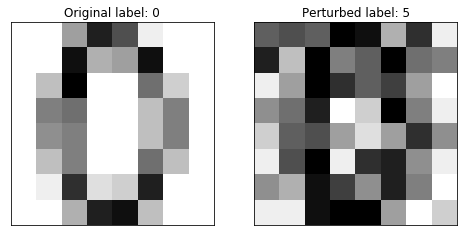

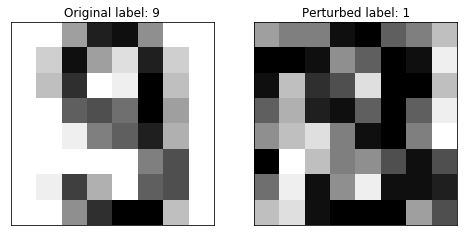

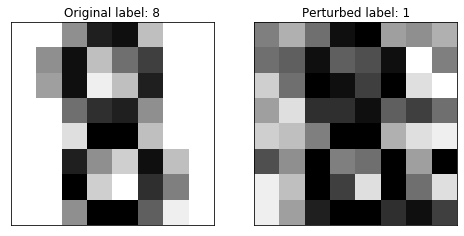

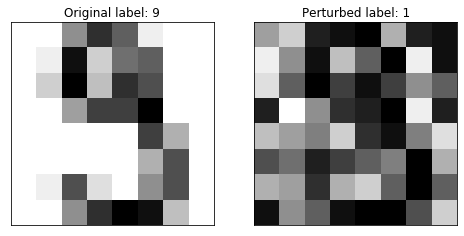

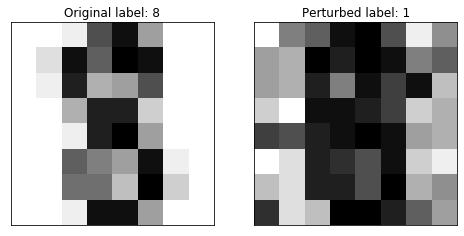

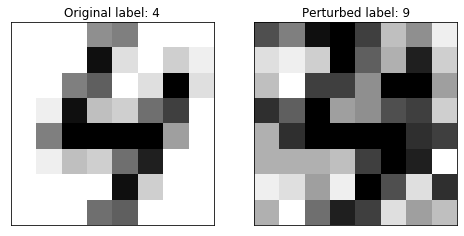

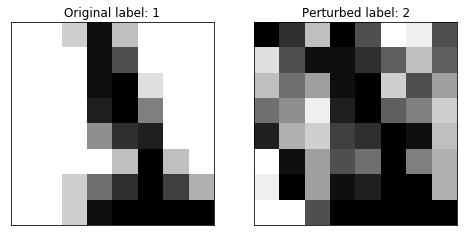

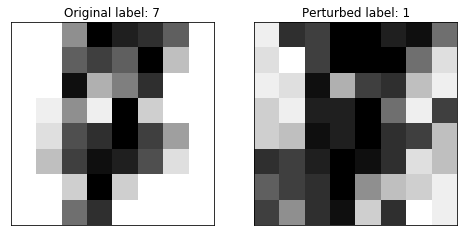

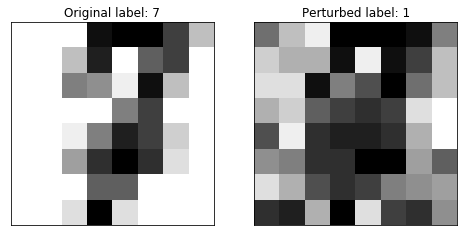

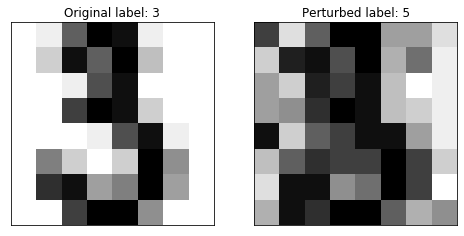

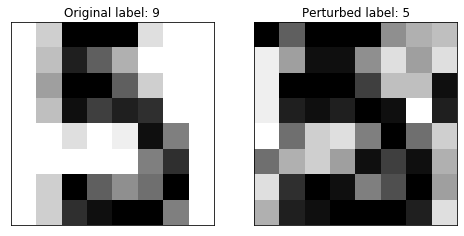

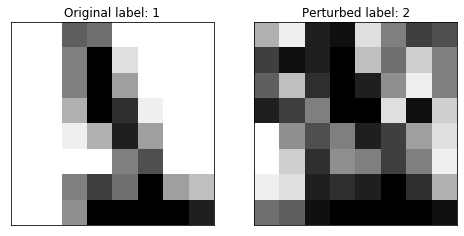

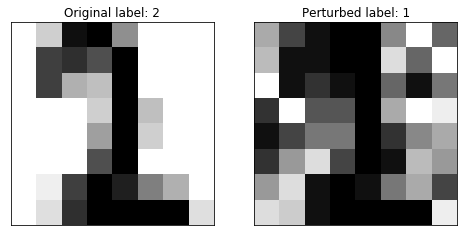

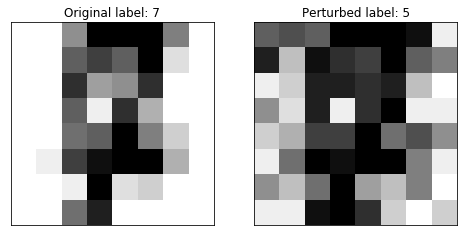

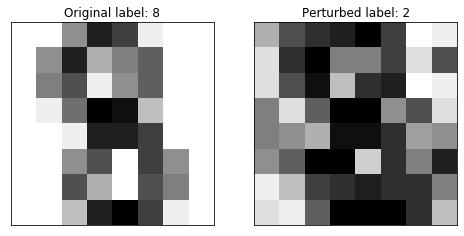

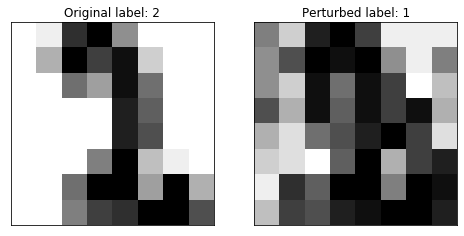

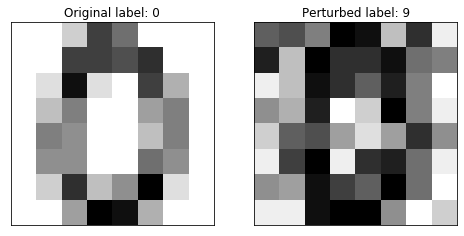

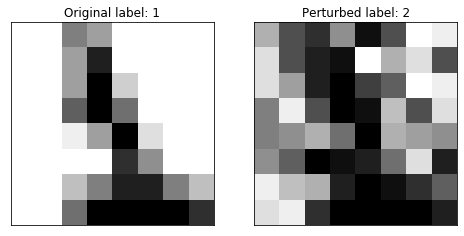

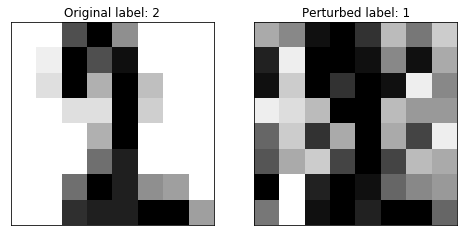

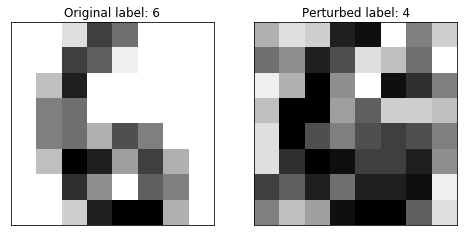

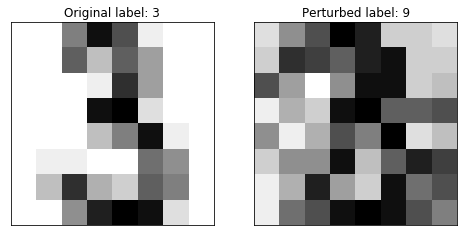

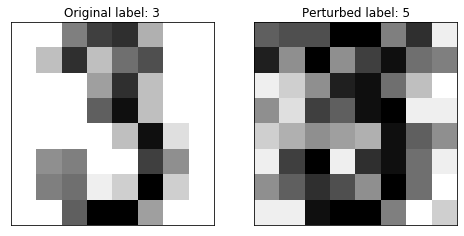

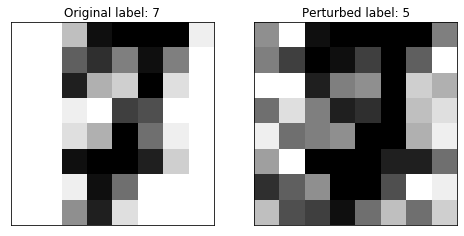

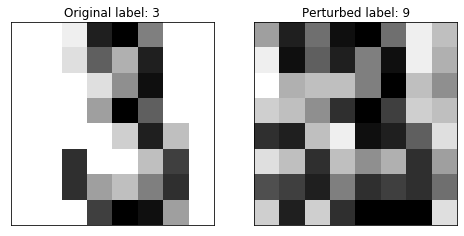

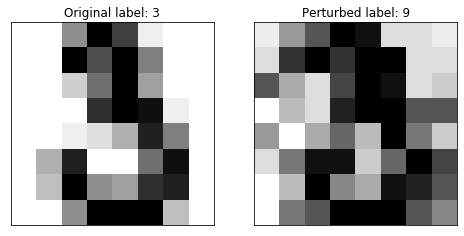

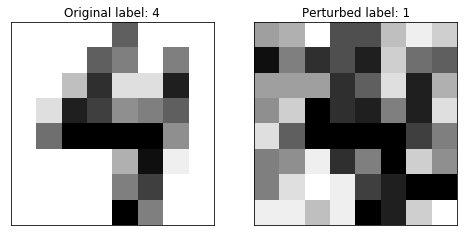

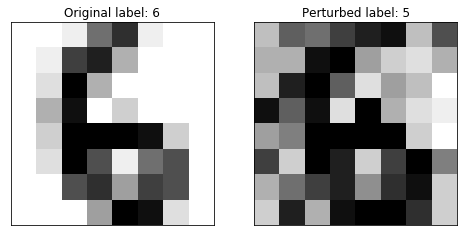

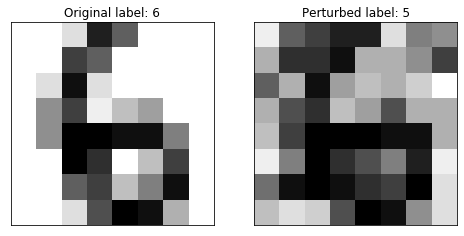

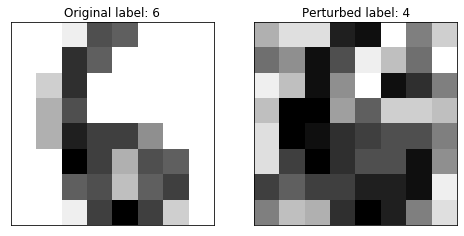

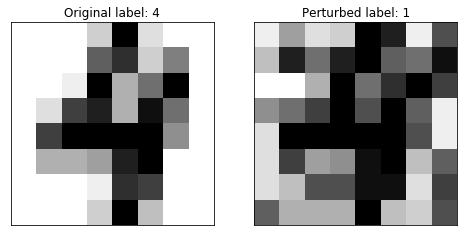

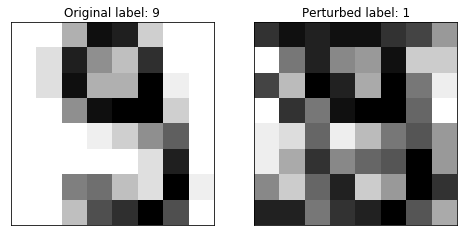

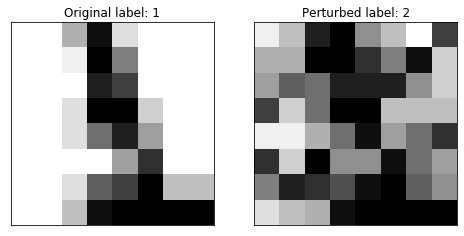

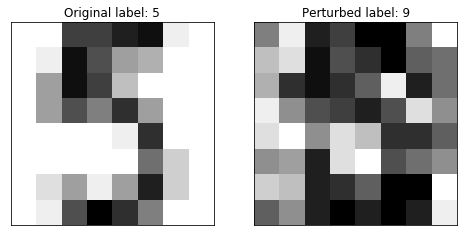

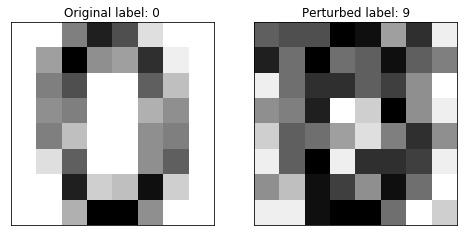

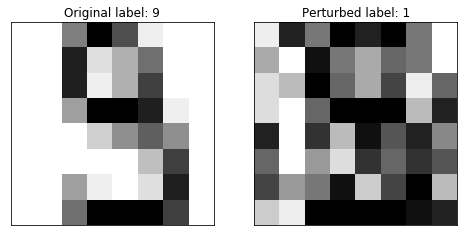

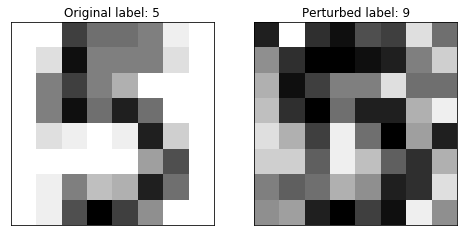

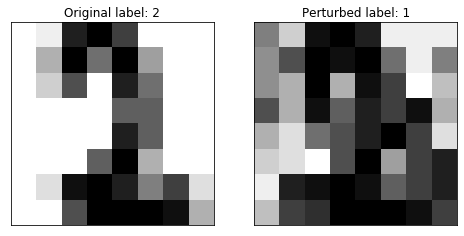

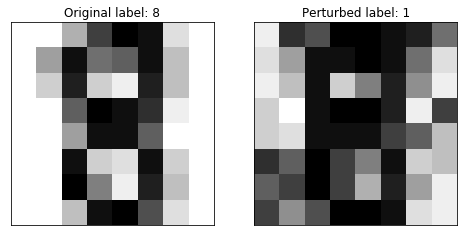

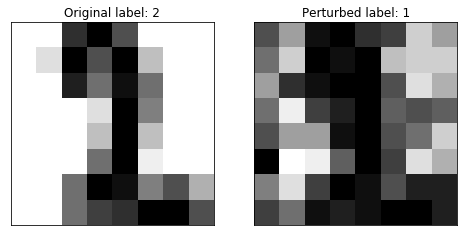

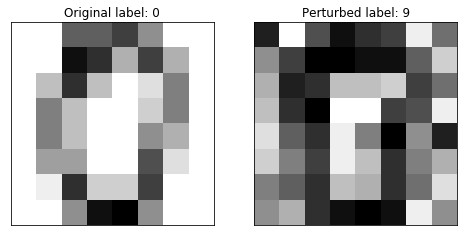

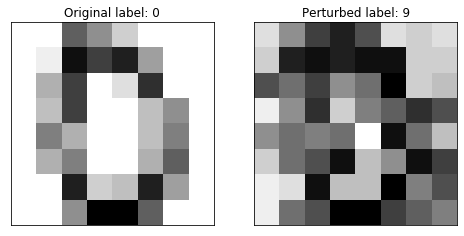

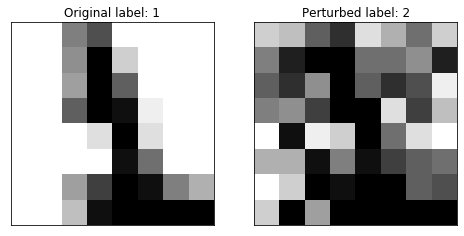

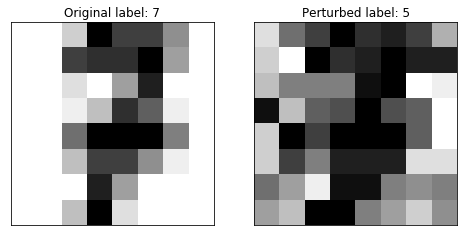

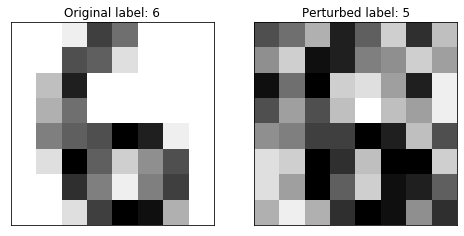

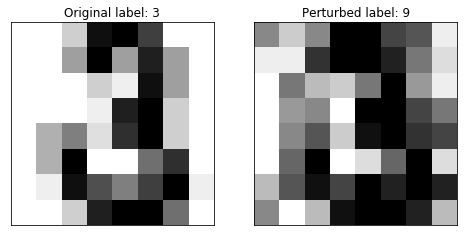

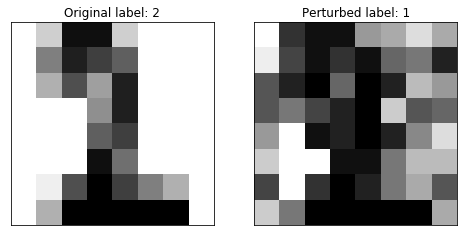

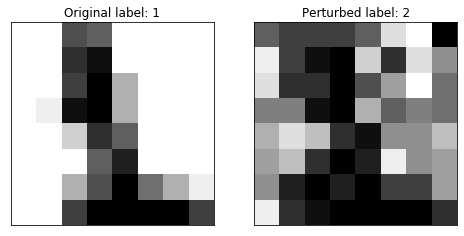

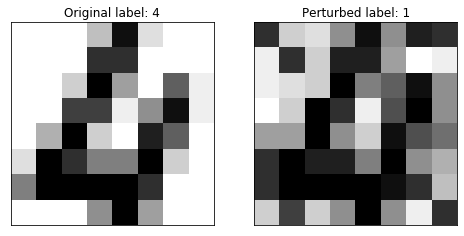

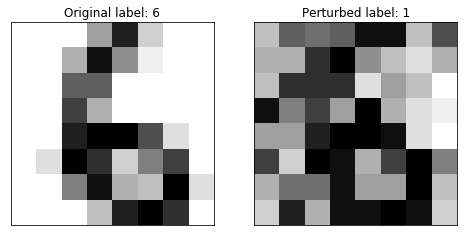

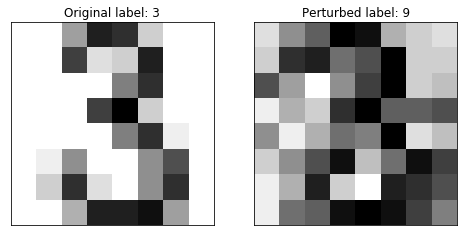

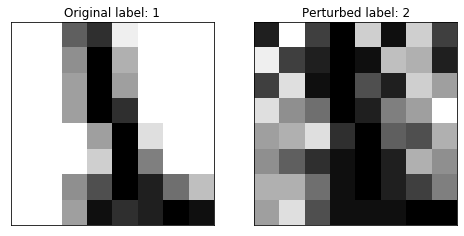

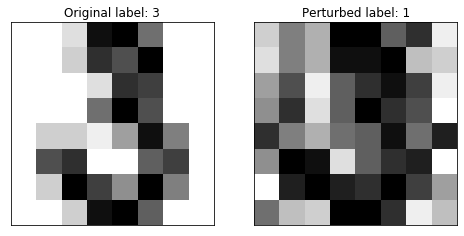

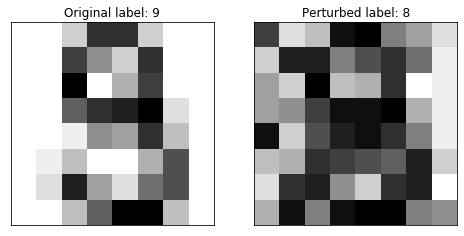

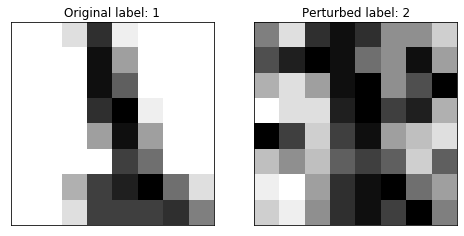

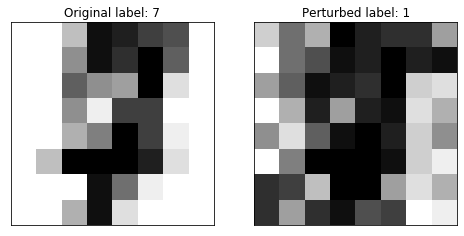

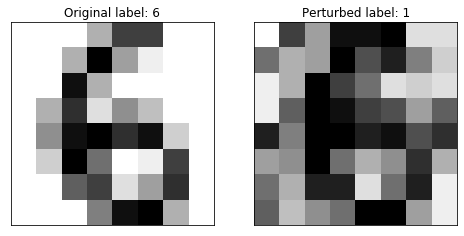

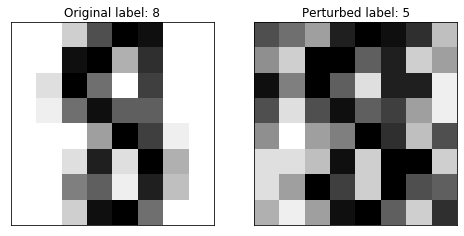

In [15]:
for i in range(n_images):
    plot_grAdapt_original_perturbed(i, ress_grAdapt)

### 4.2 grAdapt Output Data

In [16]:
data_path = 'data/'
if not os.path.exists(data_path):
    os.makedirs(data_path)

### Loss

In [17]:
y_grAdapt = np.array([res['y_sol'] for res in ress_grAdapt])
np.save(data_path+'y_grAdapt_loss', y_grAdapt)

In [18]:
x_grAdapt = np.array([res['x_sol'] for res in ress_grAdapt])
#np.save(data_path+'x_grAdapt_perturbation', x_grAdapt)

In [19]:
def is_misclassified_grAdapt(target_idx, ress):
    perturbed_image = np.array(ress[target_idx]['x_sol'] + X_test[target_idx], dtype=np.float)
    img = [X_test[target_idx], perturbed_image]
    original_label = classifier.predict(X_test[target_idx].reshape(1, -1))[0]
    perturbed_label = classifier.predict(perturbed_image.reshape(1, -1))[0]
    
    return original_label != perturbed_label

In [20]:
no_misclassified_grAdapt = np.sum([is_misclassified_grAdapt(i, ress_grAdapt) for i in range(n_images)])
np.save(data_path+'no_misclassified_grAdapt', no_misclassified_grAdapt)

### Prints

In [21]:
np.sum(y_grAdapt) # sum of loss

74.8882039785015

In [22]:
no_misclassified_grAdapt # no misclassified

100

## 5. BFGS Outputs

### 5.1 Plots

In [23]:
def plot_bfgs_original_perturbed(target_idx, ress):
    fig=plt.figure(figsize=(8, 8))
    columns = 2
    rows = 1
    perturbed_image = np.round(np.array(ress[target_idx].x + X_test[target_idx], dtype=np.float))
    img = [X_test[target_idx], perturbed_image]
    original_label = classifier.predict(X_test[target_idx].reshape(1, -1))[0]
    perturbed_label = classifier.predict(perturbed_image.reshape(1, -1))[0]
    labels = ['Original label: '+str(original_label), 'Perturbed label: '+str(perturbed_label)]
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i, title=labels[i-1]+str())
        plt.imshow(img[i-1].reshape(8, 8), cmap=plt.cm.binary)
        plt.xticks([], [])
        plt.yticks([], [])
        
    plot_filepath = plot_path+'bfgs_'+str(target_idx)+'.pdf'
    plt.savefig(plot_filepath, bbox_inches='tight')
    plt.show()

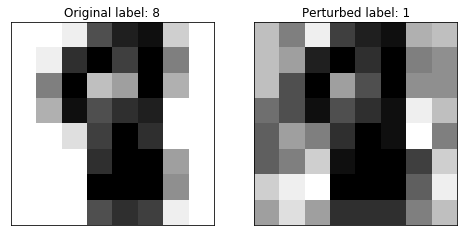

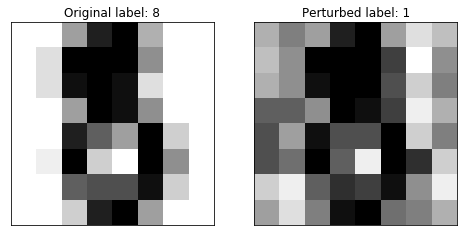

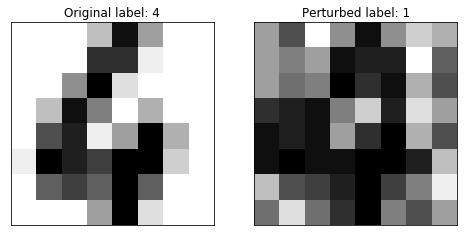

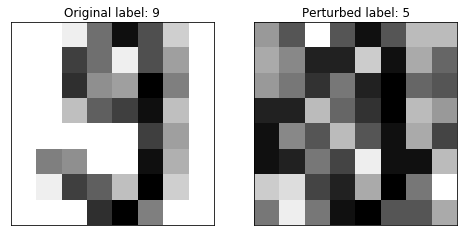

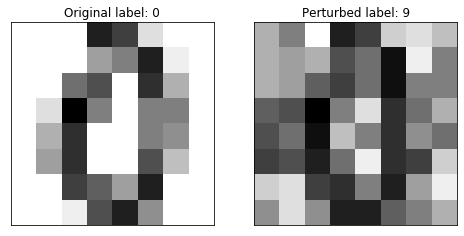

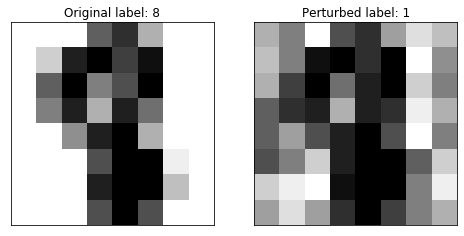

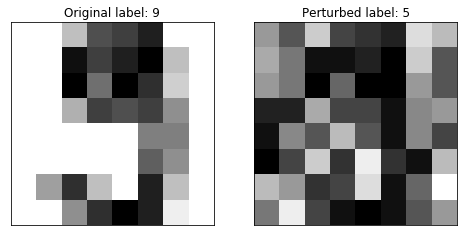

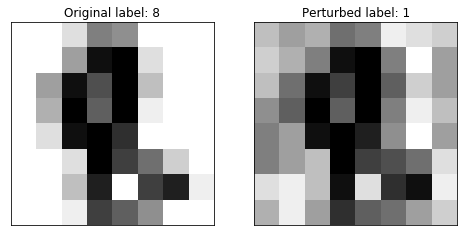

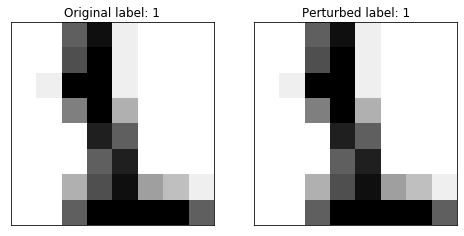

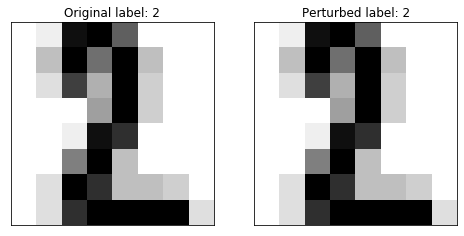

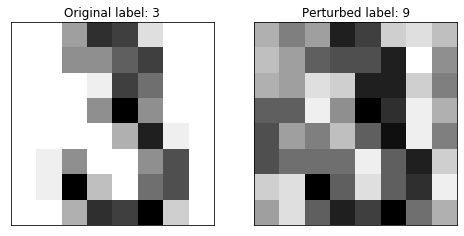

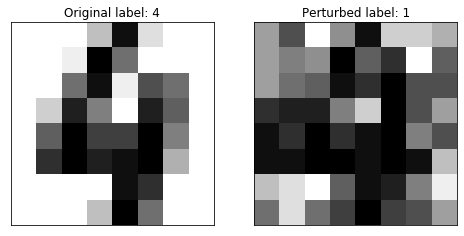

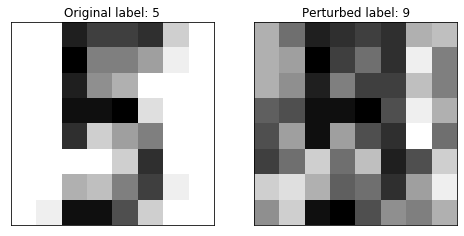

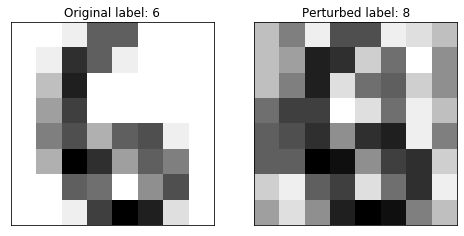

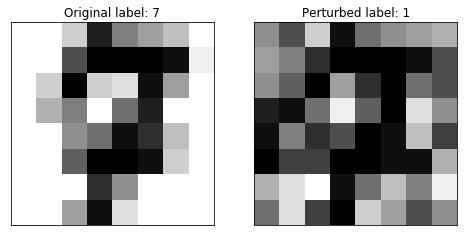

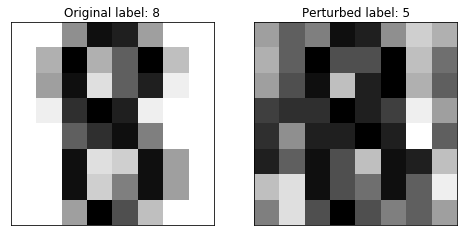

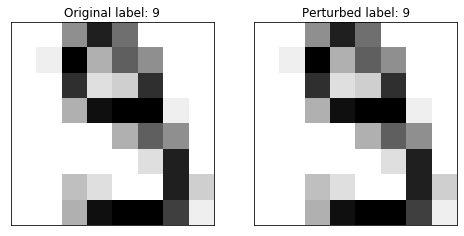

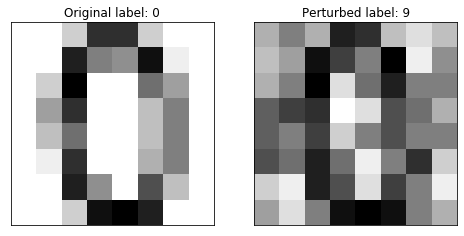

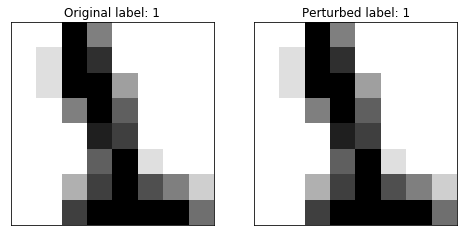

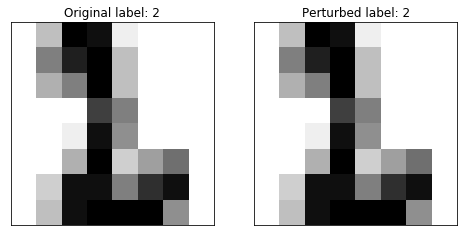

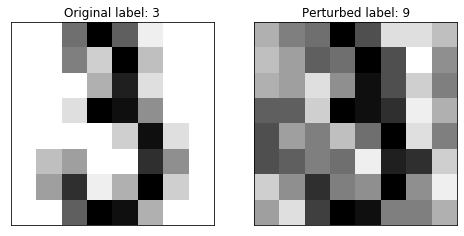

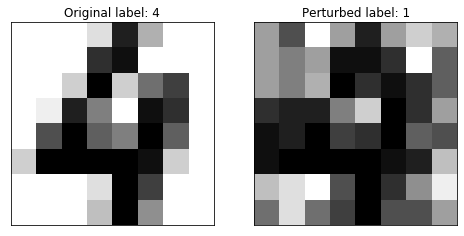

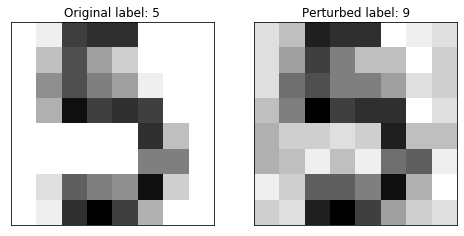

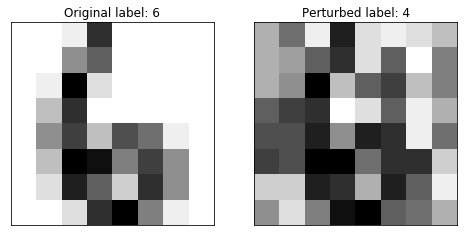

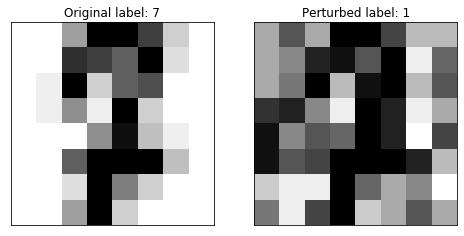

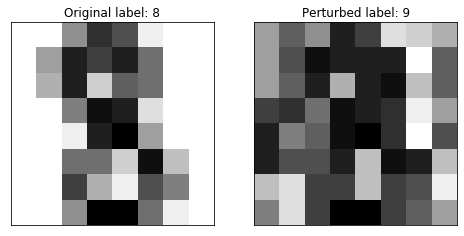

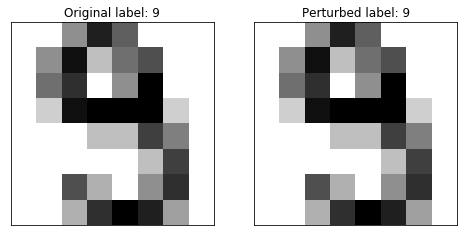

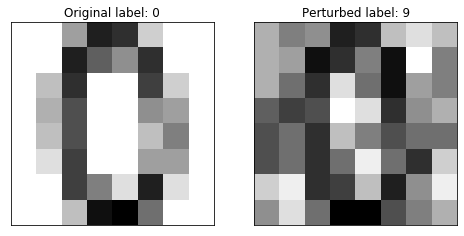

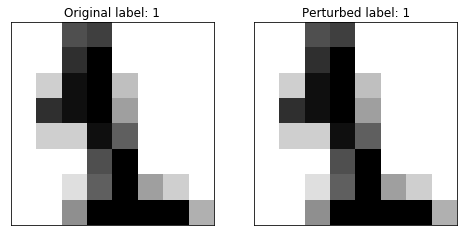

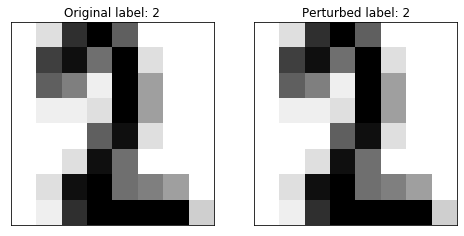

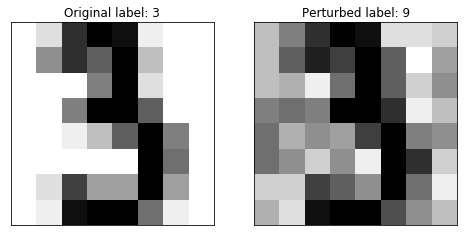

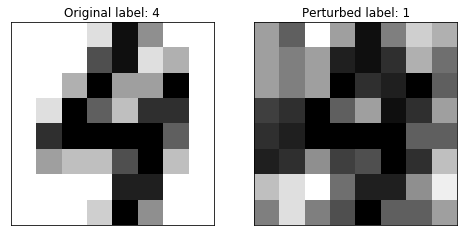

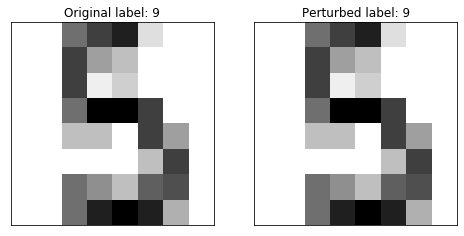

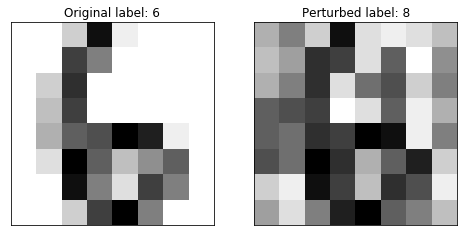

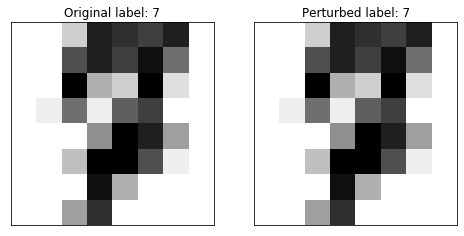

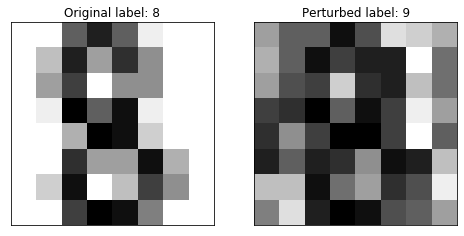

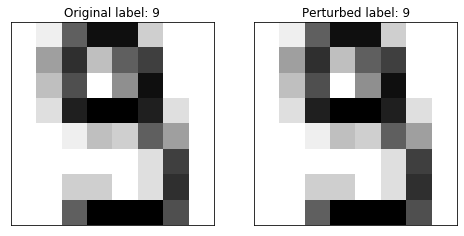

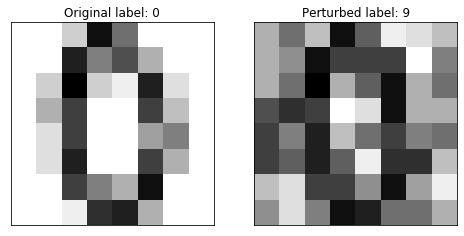

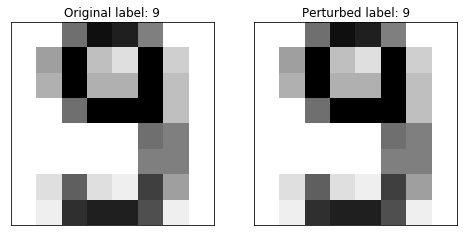

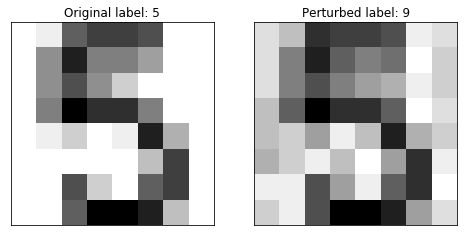

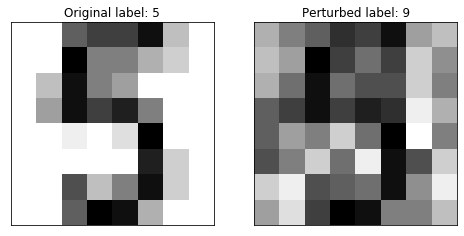

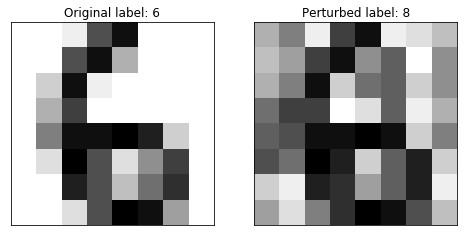

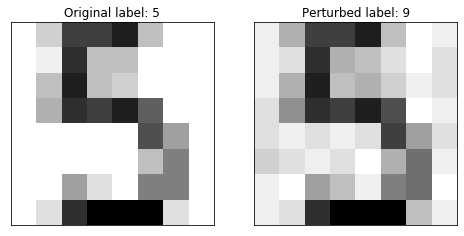

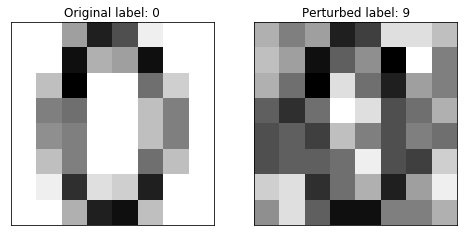

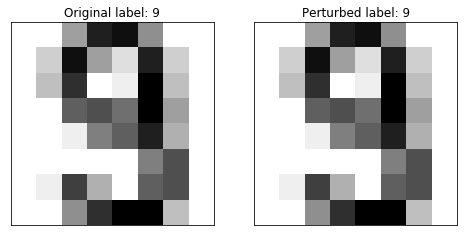

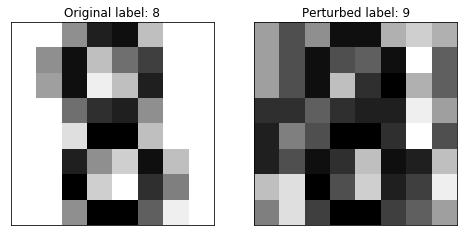

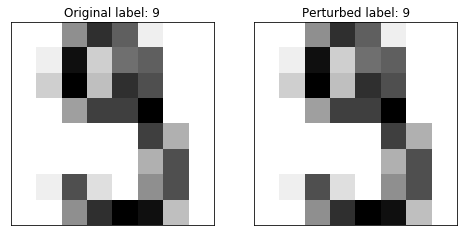

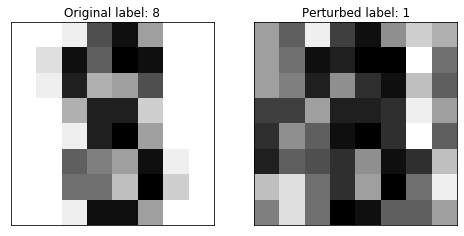

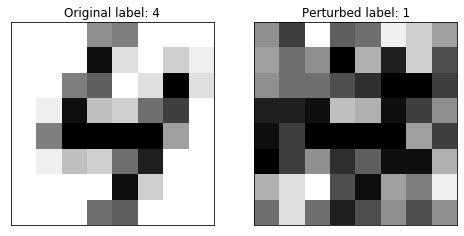

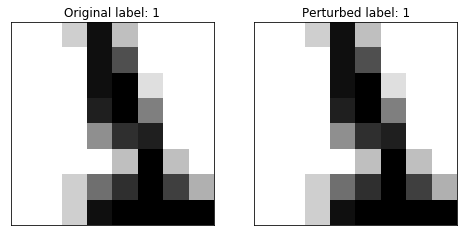

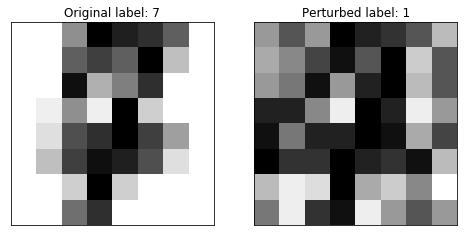

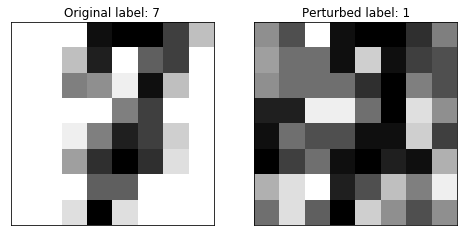

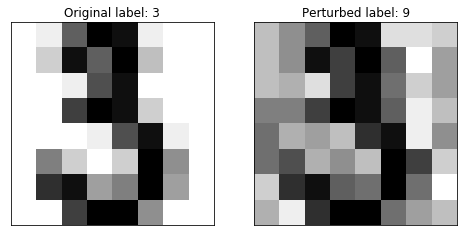

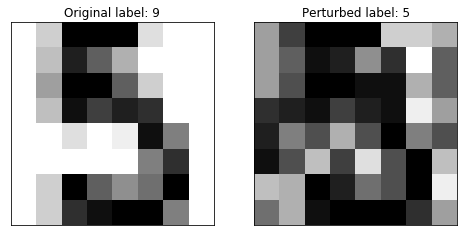

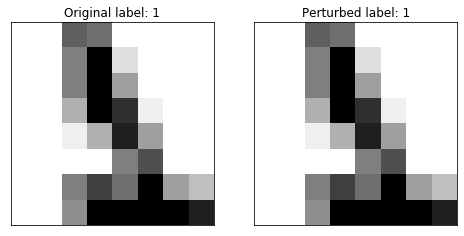

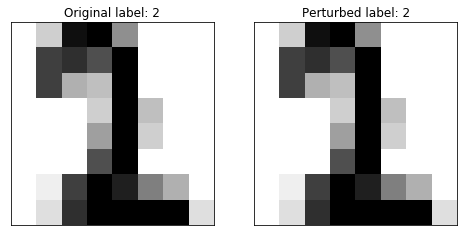

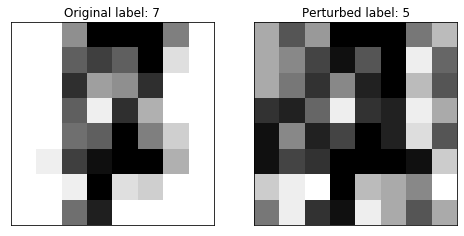

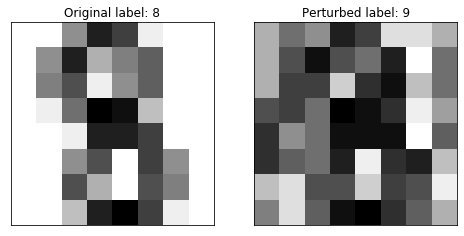

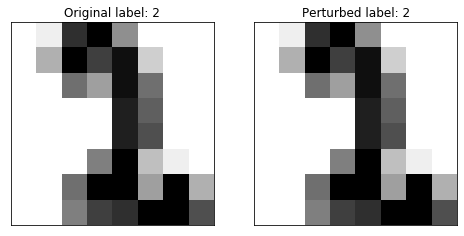

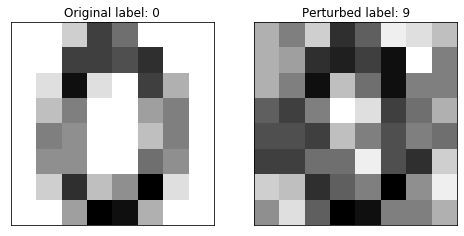

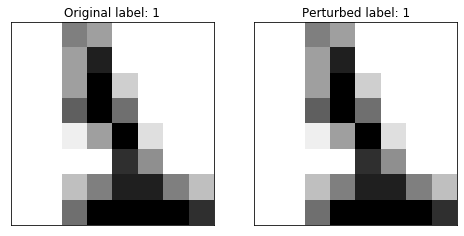

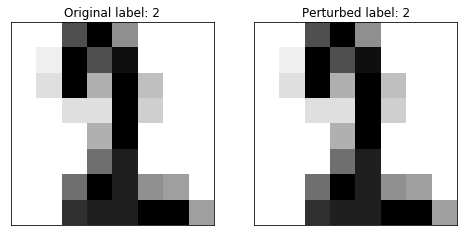

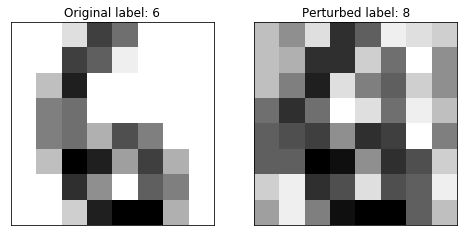

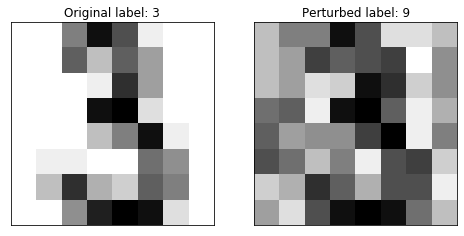

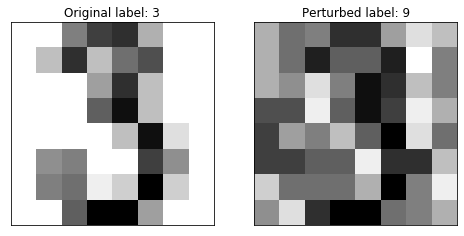

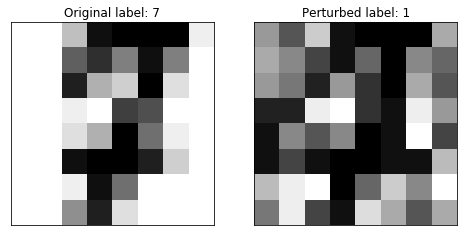

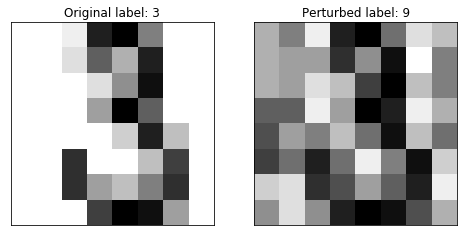

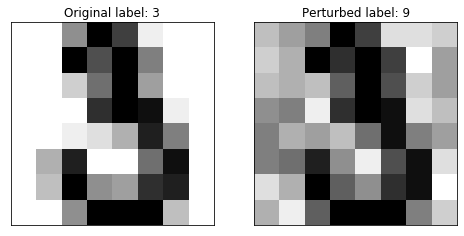

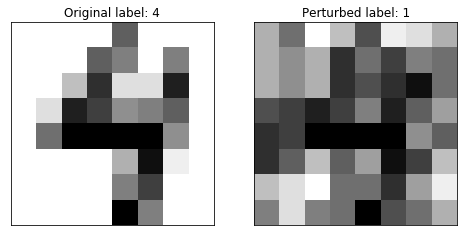

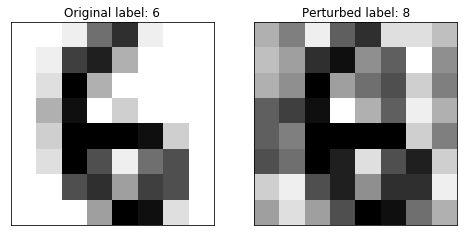

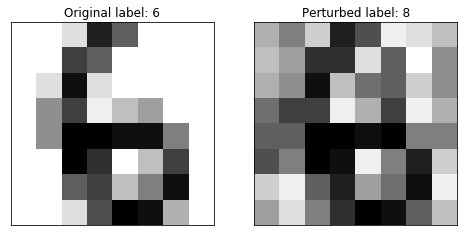

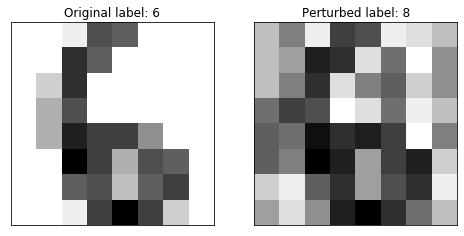

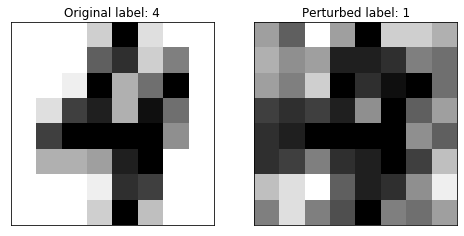

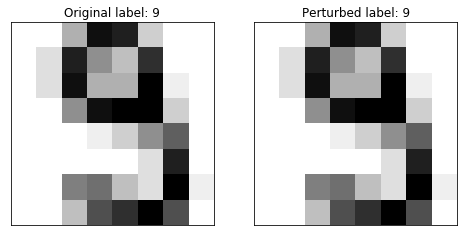

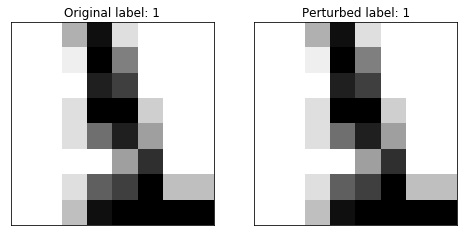

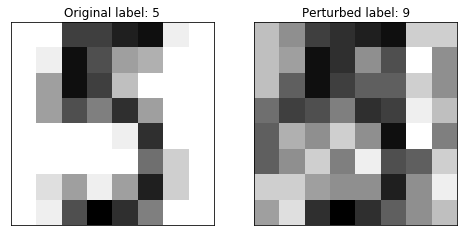

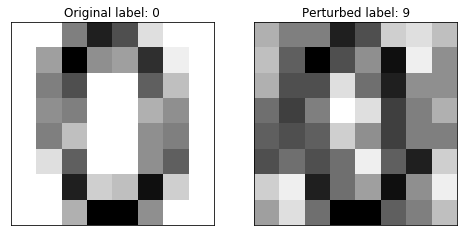

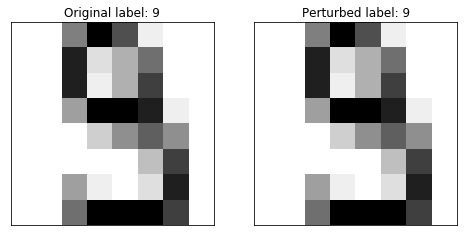

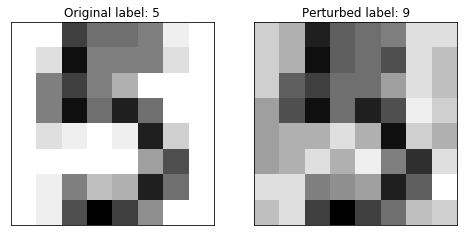

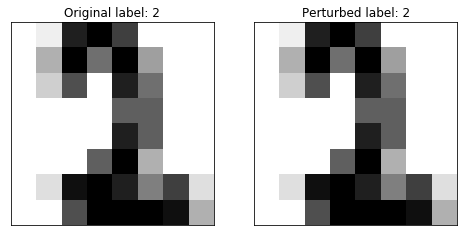

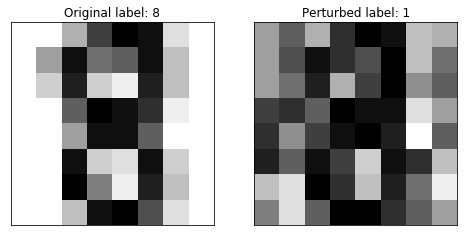

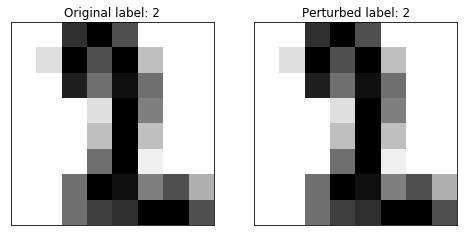

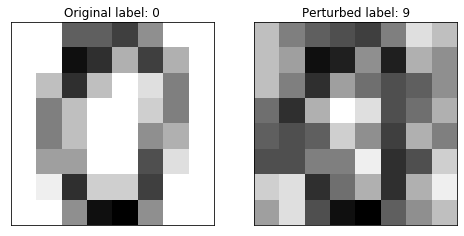

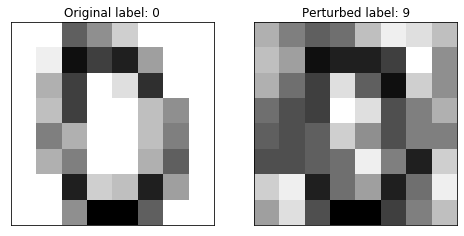

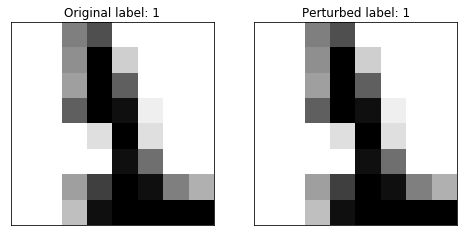

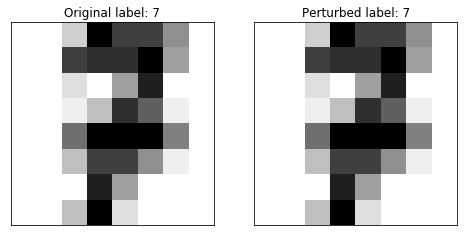

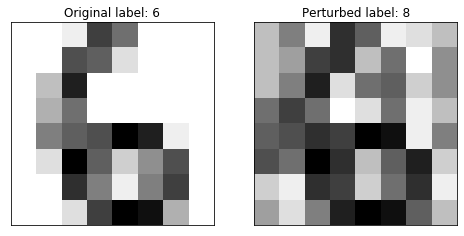

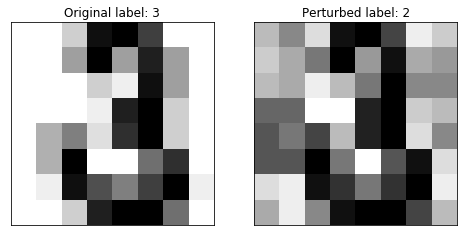

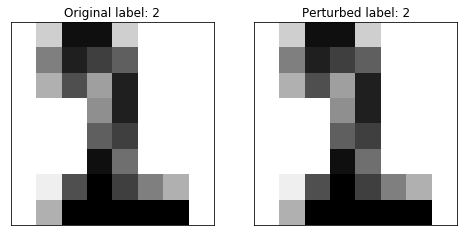

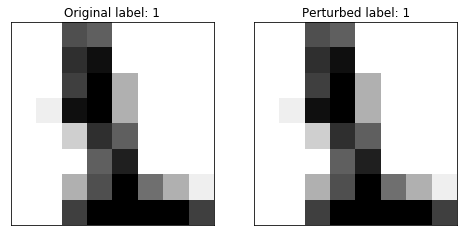

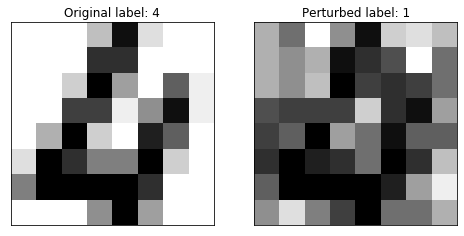

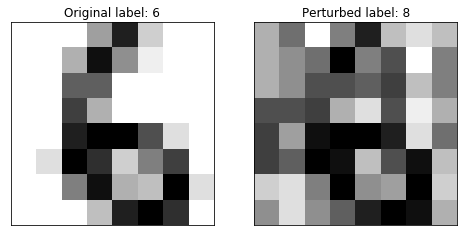

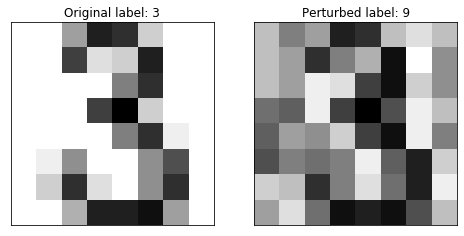

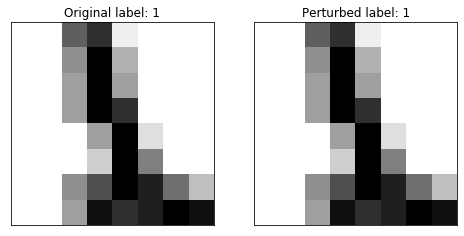

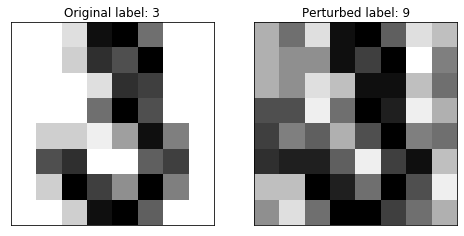

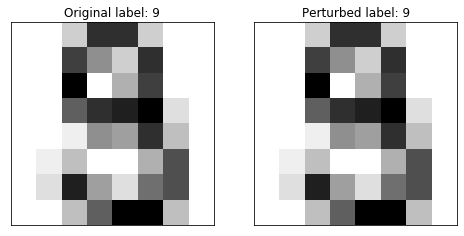

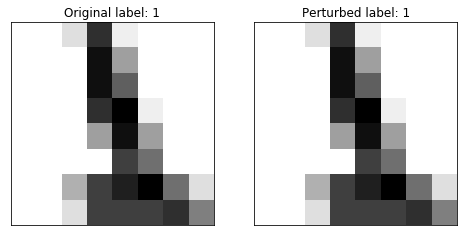

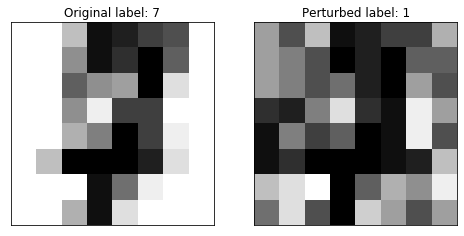

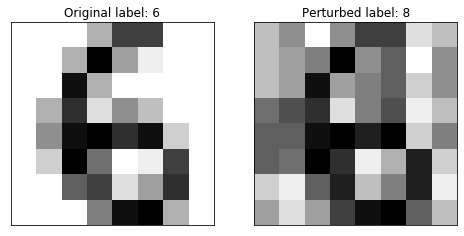

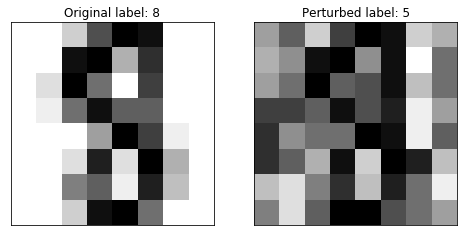

In [24]:
for i in range(n_images):
    plot_bfgs_original_perturbed(i, ress_bfgs)

### 5.2 BFGS Output Data

In [25]:
y_bfgs = np.array([res.fun for res in ress_bfgs])
np.save(data_path+'y_bfgs_loss', y_bfgs)

In [26]:
x_bfgs = np.array([res.x for res in ress_bfgs])
np.save(data_path+'x_bfgs_perturbation', x_bfgs)

In [27]:
def is_misclassified_bfgs(target_idx, ress):
    perturbed_image = np.round(np.array(ress[target_idx].x + X_test[target_idx], dtype=np.float))
    img = [X_test[target_idx], perturbed_image]
    original_label = classifier.predict(X_test[target_idx].reshape(1, -1))[0]
    perturbed_label = classifier.predict(perturbed_image.reshape(1, -1))[0]
    
    return original_label != perturbed_label

In [28]:
no_misclassified_bfgs = np.sum([is_misclassified_bfgs(i, ress_bfgs) for i in range(n_images)])
np.save(data_path+'no_misclassified_bfgs', no_misclassified_bfgs)

In [29]:
n_evals_bfgs = np.array([res.nfev for res in ress_bfgs])
np.save(data_path+'n_evals_bfgs', n_evals_bfgs)

### Prints

In [30]:
np.sum(y_bfgs) # sum of loss

97.72102937135963

In [31]:
no_misclassified_bfgs

68

In [32]:
np.sum(n_evals_bfgs)

438165

In [33]:
n_evals_bfgs

array([ 5265,  4420,  8060,  8840,  4550,  7995,  5720,  5135,   650,
         195,  4225,  3250,  8060,  7670,  6955,  4290,   260,  6045,
         195,   650,  4420,  5850,  4680,  4290,  6630,  6890,   260,
        7800,   195,   260,  6370,  4940,   195,  5720,   260,  6630,
         260,  4290,   650,  7085,  4550,  5850,  7085,  5395,   260,
        6630,   260,  6760,  5915,   650,  5330,  3380,  8060,  9165,
         650,   650,  7215,  6695,   975,  7540,   650,  1040,  8190,
        7020,  7930,  6955,  5525,  7930,  3250,  5720,  7995,  4420,
        5005,   650,   260,  6500,  8450,   260,  5785,   260,  5590,
         195,  5525,  4745,   260,   650,  9490,  6110,   260,   260,
        8840,  3900, 10270,   260,  5915,   195,   650,  4875,  7995,
        5265])

## 6. grAdapt and BFGS Plots together

In [34]:
def plot_grAdapt_bfgs_original_perturbed(target_idx, ress_grAdapt, ress_bfgs):
    fig=plt.figure(figsize=(10, 10))
    columns = 3
    rows = 1
    perturbed_image_grAdapt = np.array(ress_grAdapt[target_idx]['x_sol'] + X_test[target_idx], dtype=np.float) # grAdapt
    perturbed_image_bfgs = np.round(np.array(ress_bfgs[target_idx].x + X_test[target_idx], dtype=np.float)) # bfgs
    img = [X_test[target_idx], perturbed_image_grAdapt, perturbed_image_bfgs]
    original_label = classifier.predict(X_test[target_idx].reshape(1, -1))[0]
    perturbed_label_grAdapt = classifier.predict(perturbed_image_grAdapt.reshape(1, -1))[0]
    perturbed_label_bfgs = classifier.predict(perturbed_image_bfgs.reshape(1, -1))[0]
    labels = ['Original label: '+str(original_label), 'Perturbed label (grAdapt): '+str(perturbed_label_grAdapt), 'Perturbed label (BFGS-B): '+str(perturbed_label_bfgs)]
    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i, title=labels[i-1]+str())
        plt.imshow(img[i-1].reshape(8, 8), cmap=plt.cm.binary)
        plt.xticks([], [])
        plt.yticks([], [])
    plot_filepath = plot_path+'grAdapt_bfgs_'+str(target_idx)+'.pdf'
    plt.savefig(plot_filepath, bbox_inches='tight')
    plt.show()

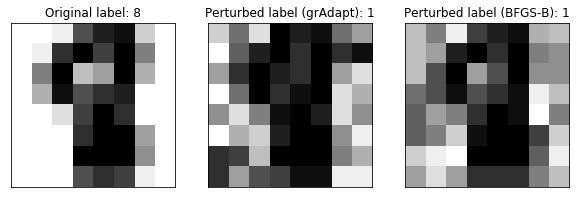

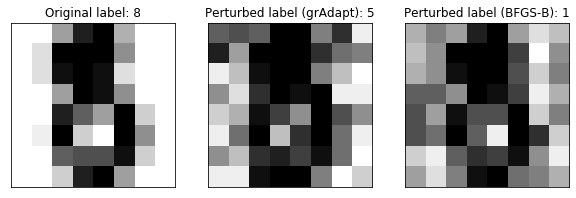

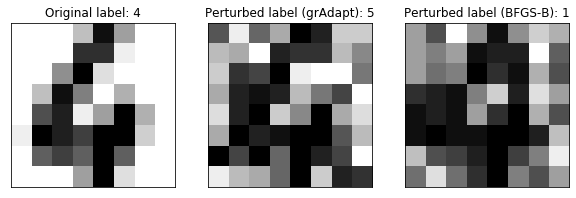

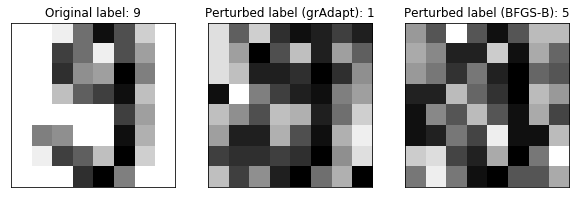

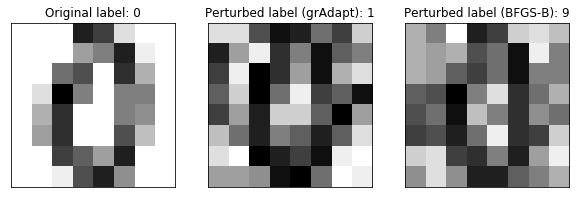

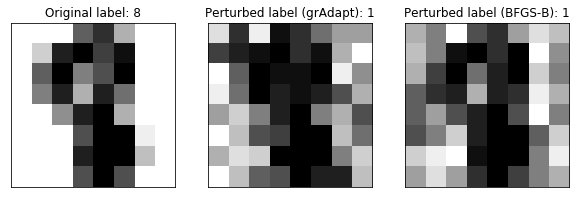

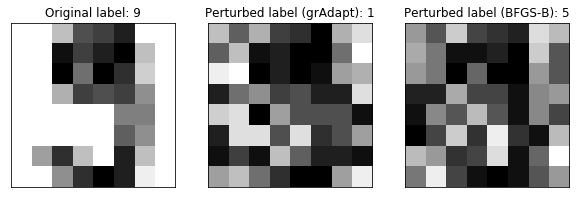

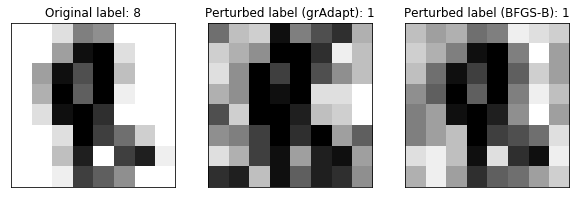

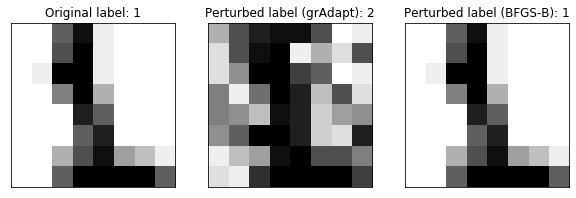

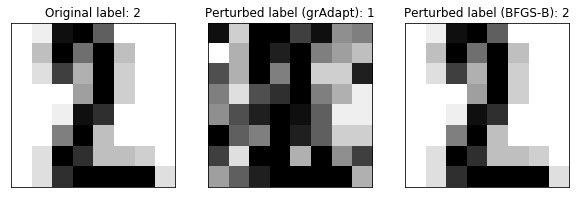

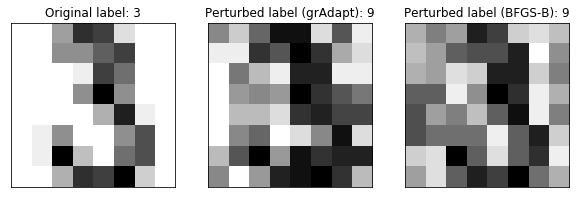

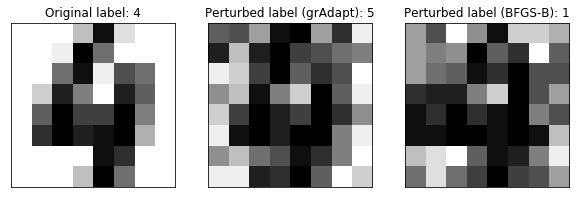

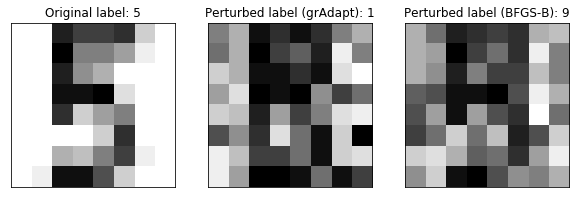

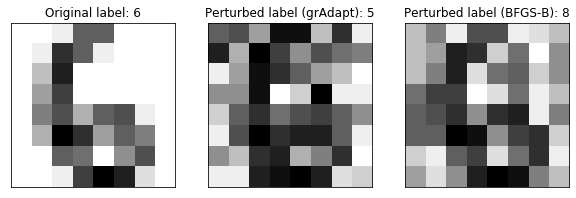

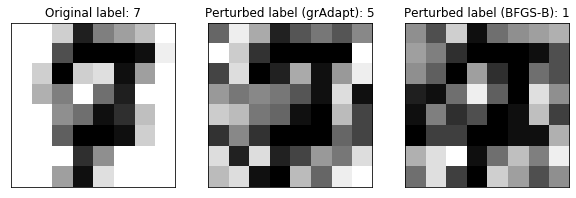

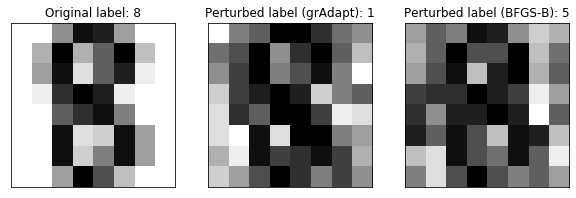

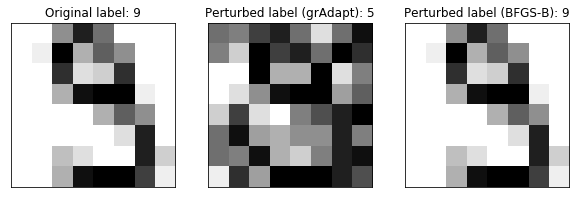

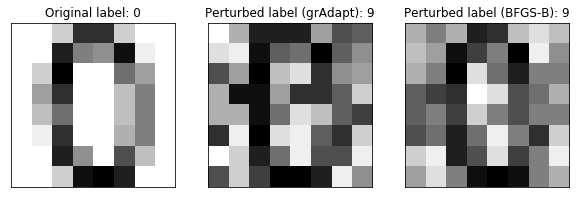

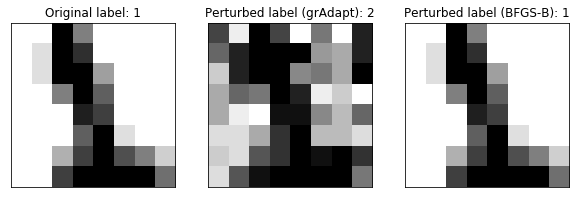

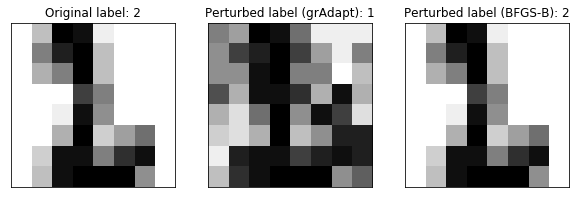

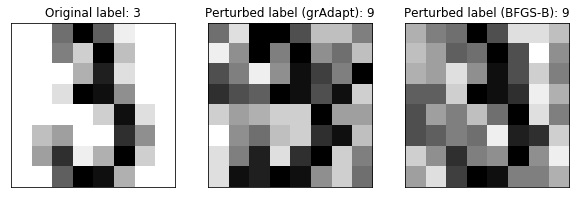

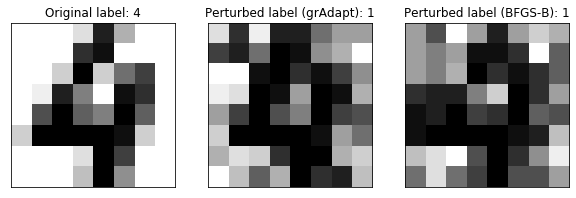

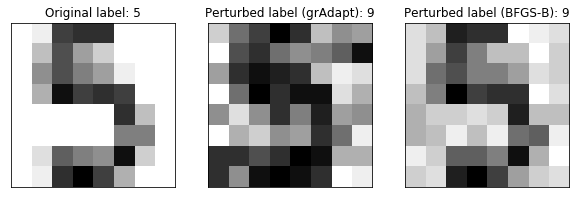

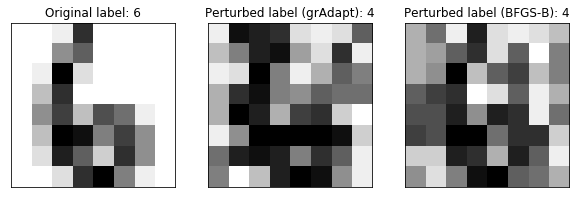

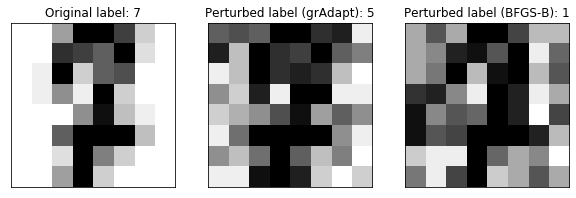

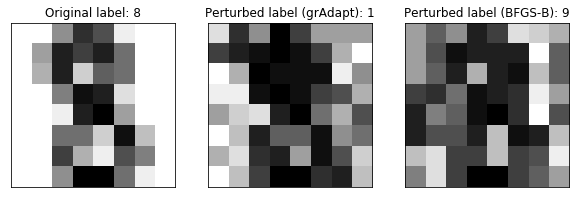

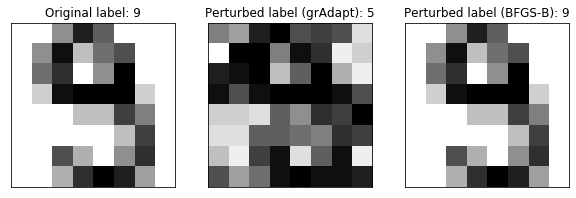

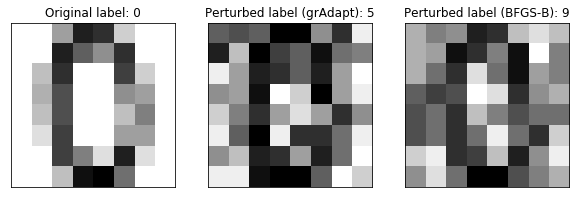

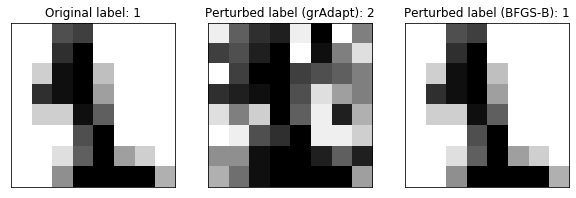

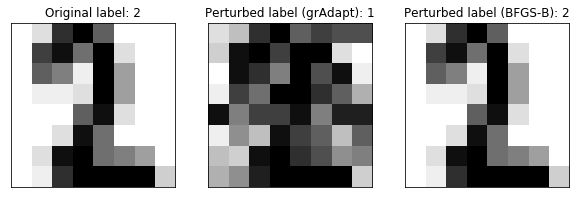

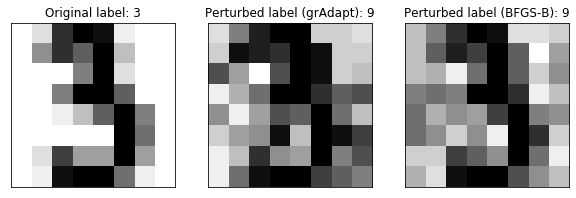

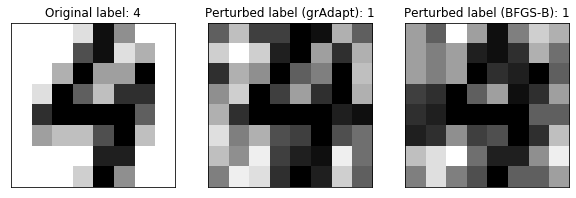

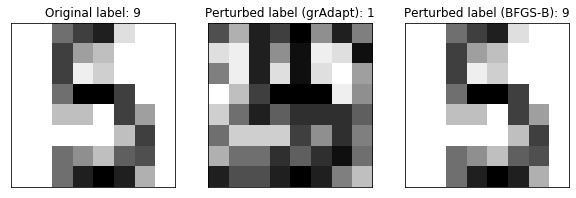

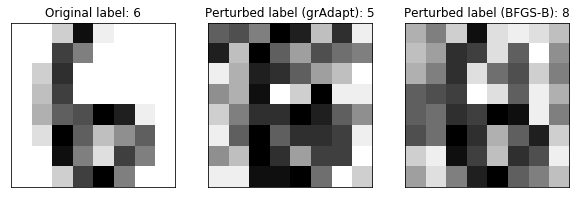

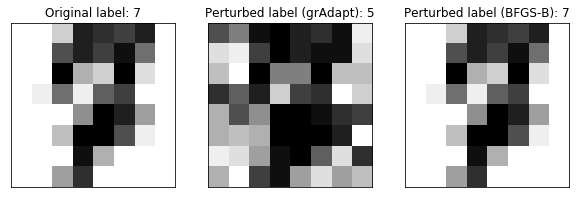

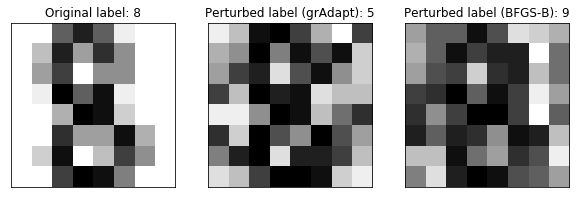

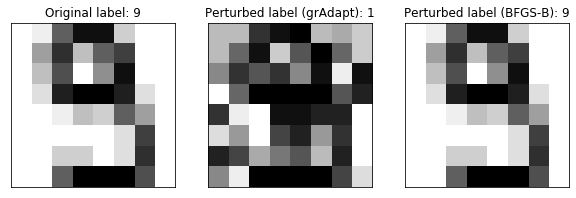

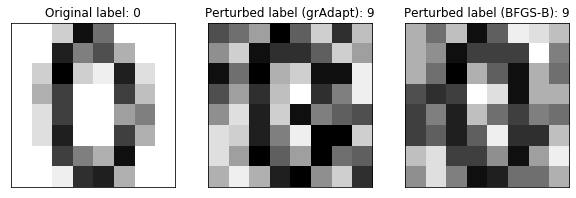

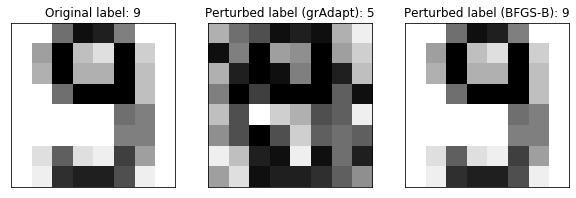

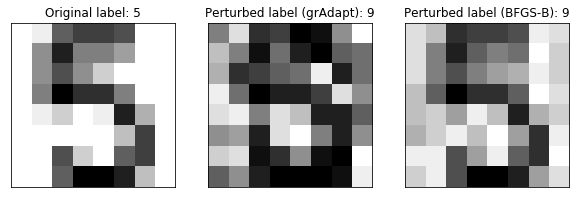

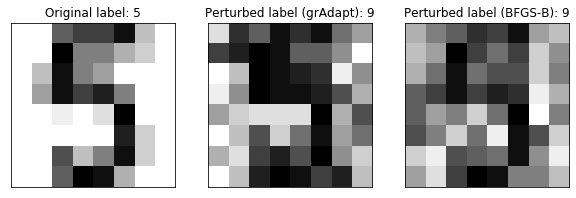

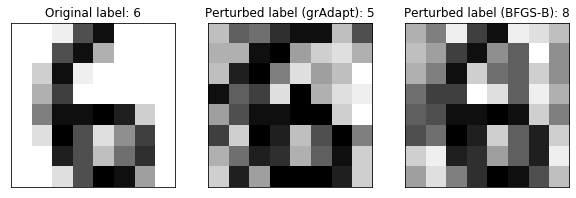

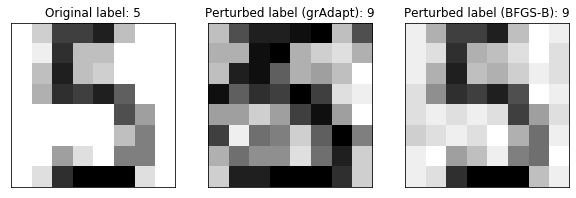

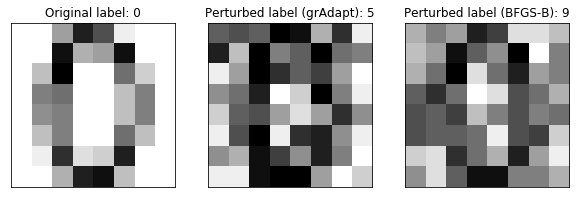

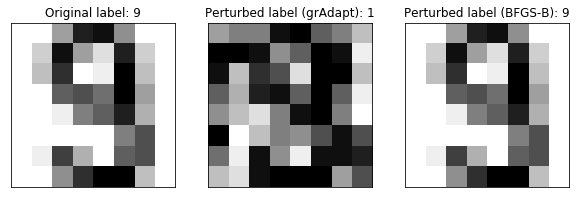

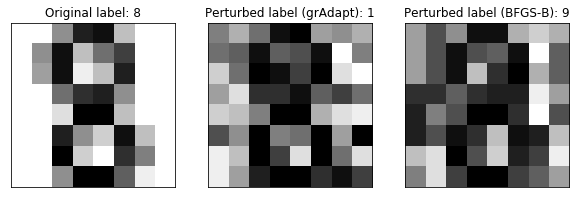

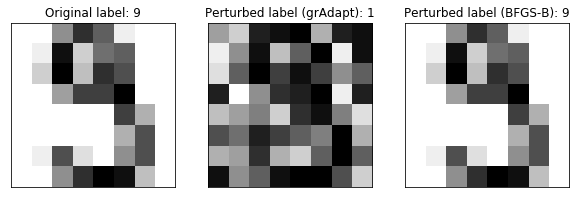

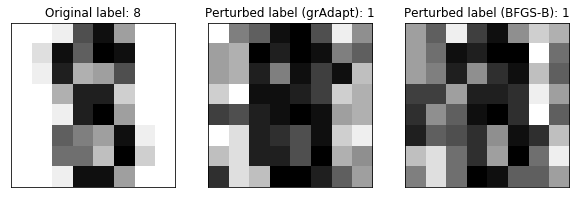

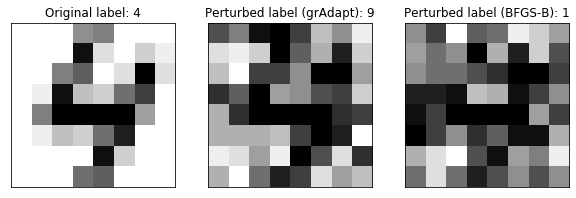

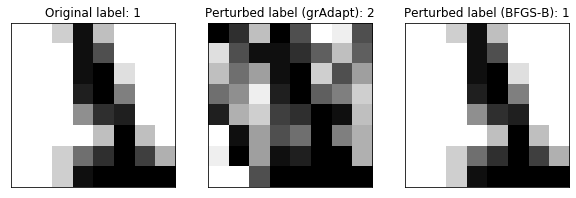

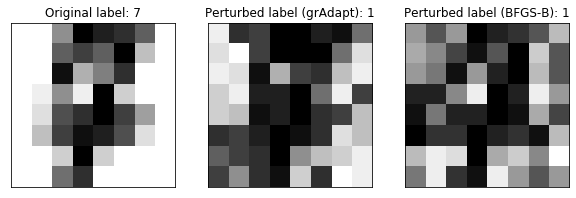

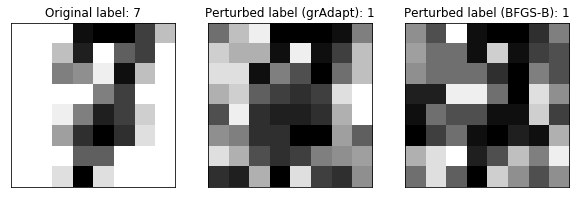

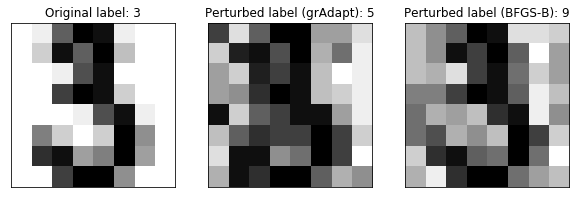

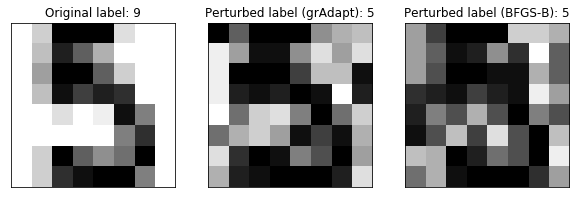

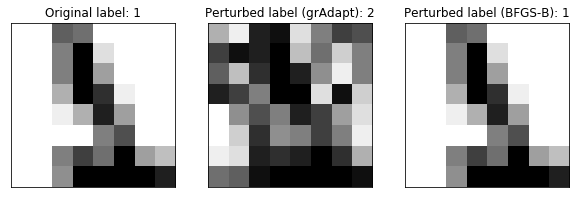

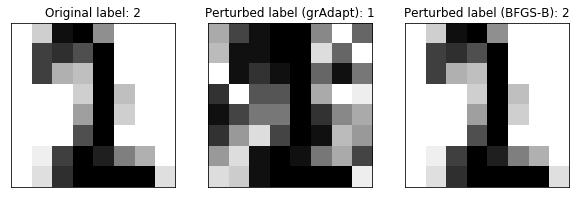

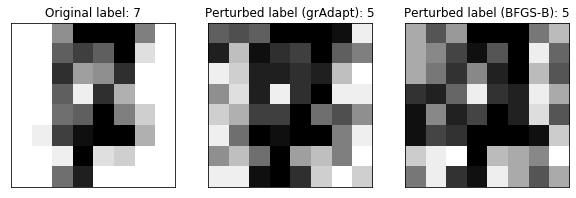

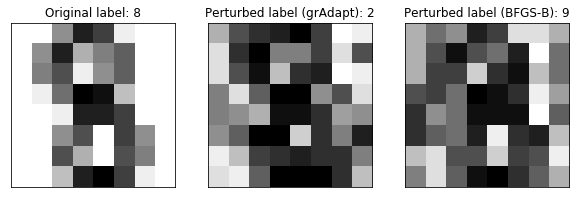

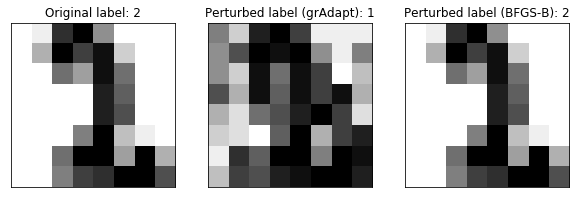

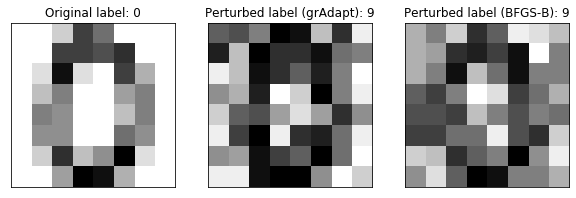

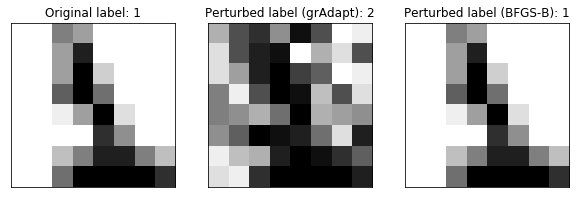

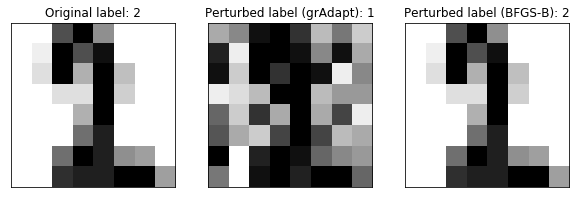

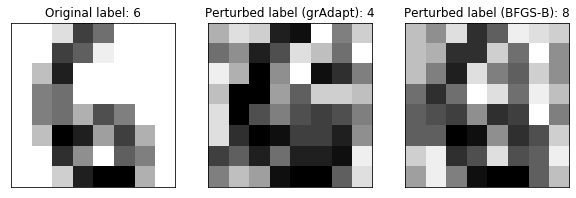

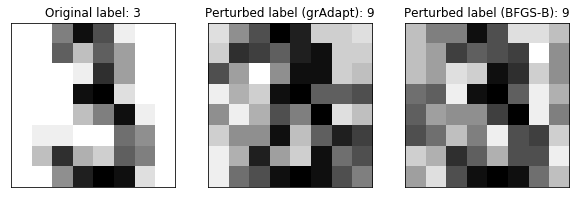

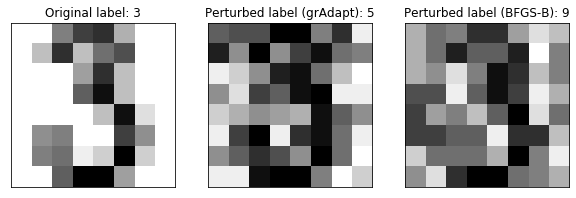

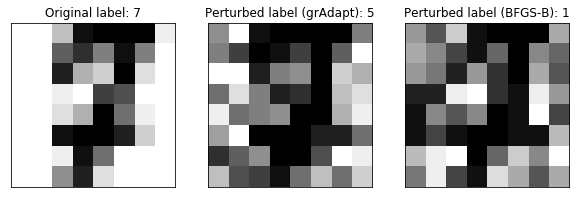

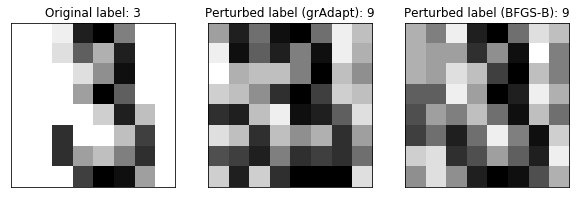

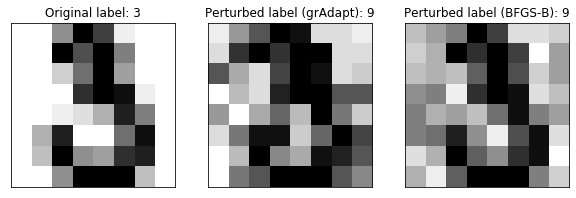

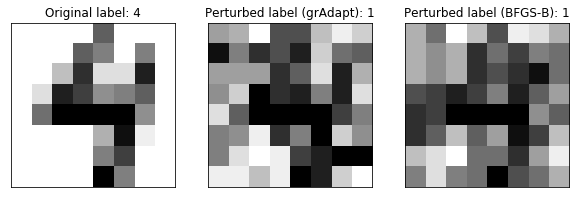

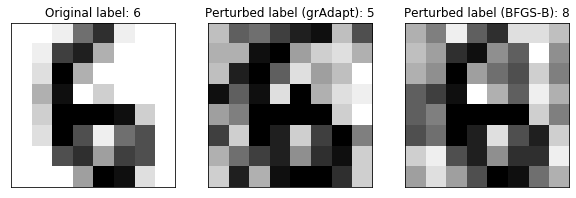

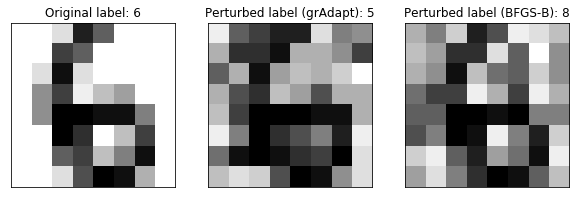

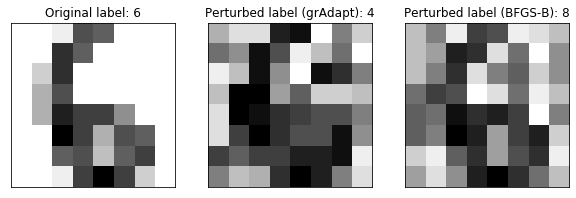

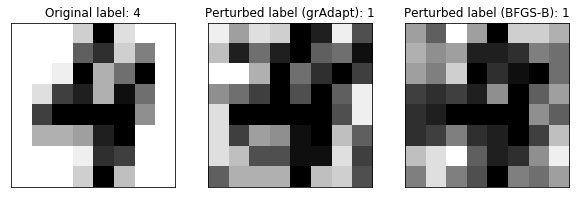

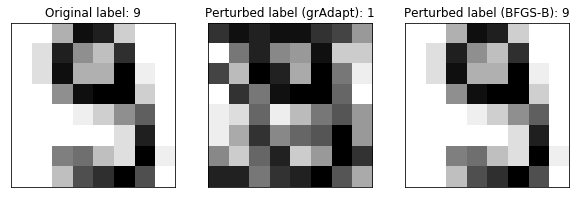

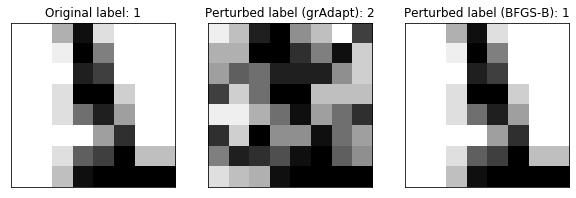

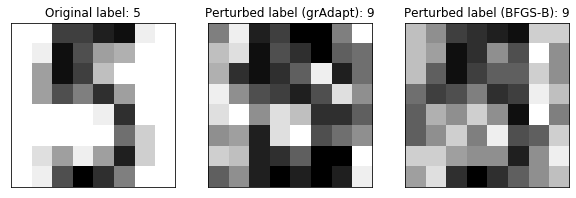

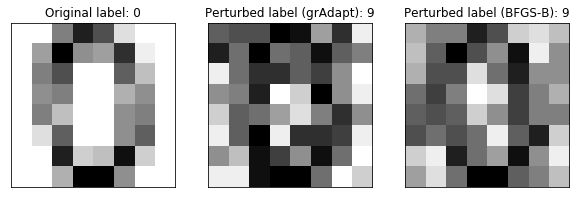

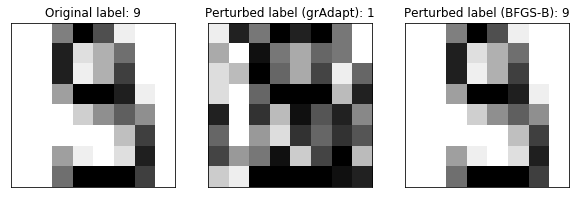

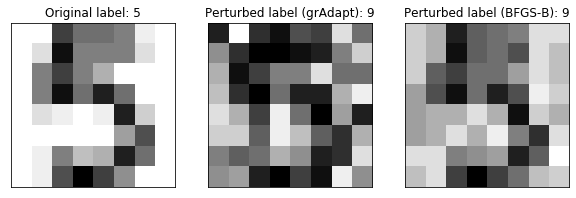

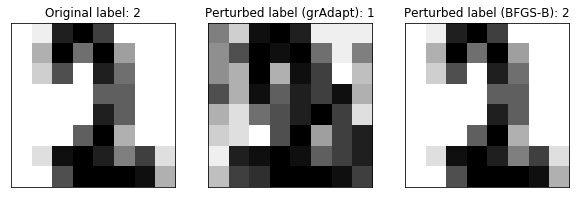

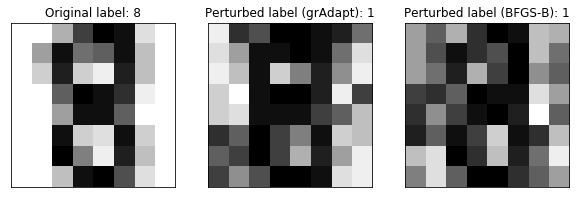

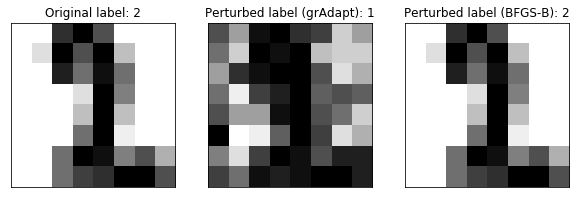

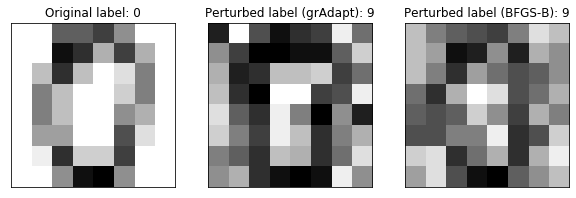

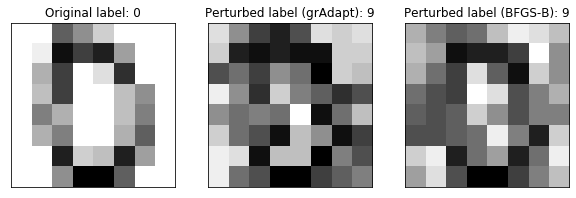

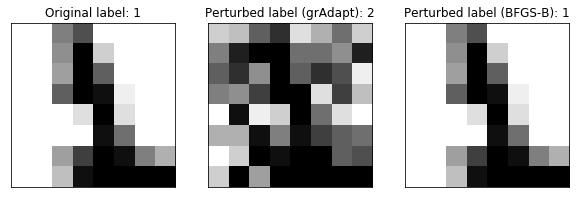

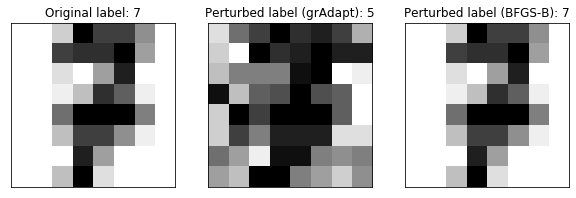

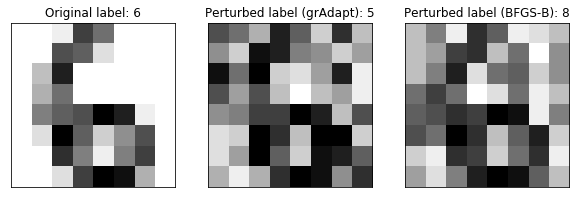

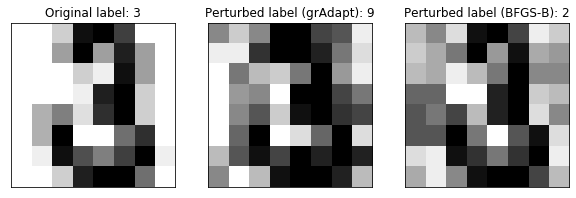

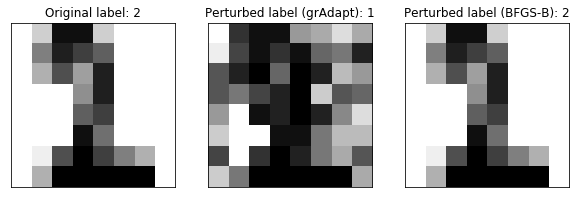

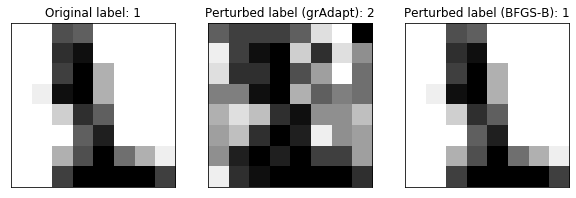

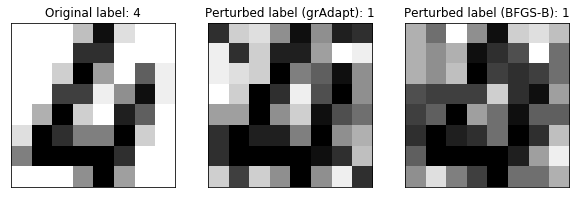

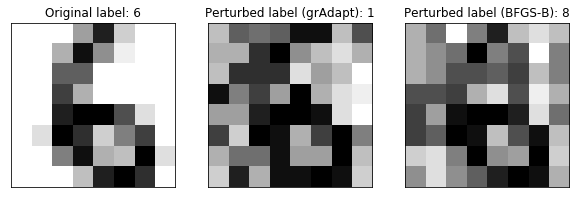

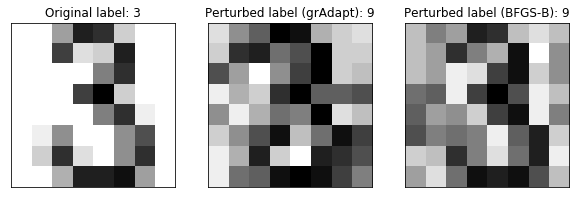

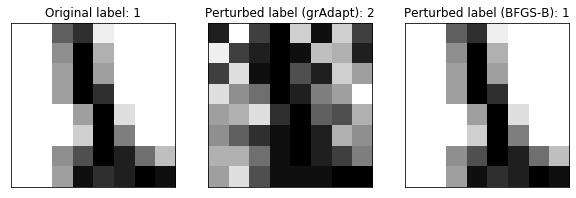

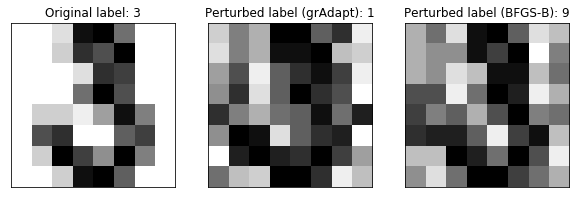

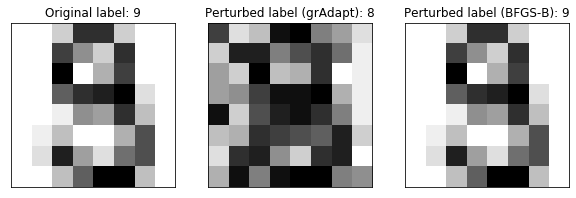

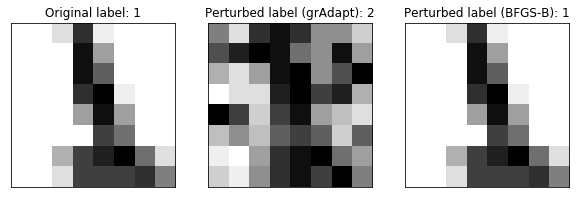

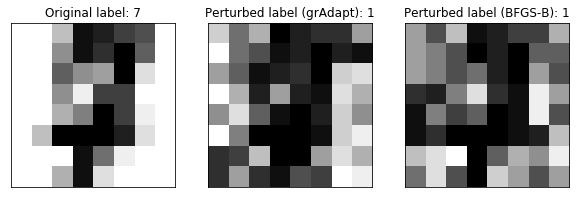

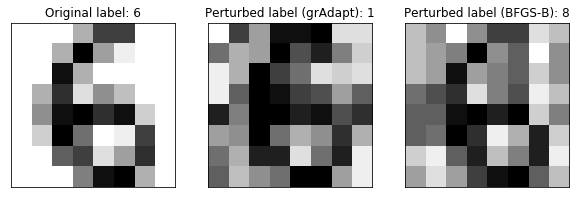

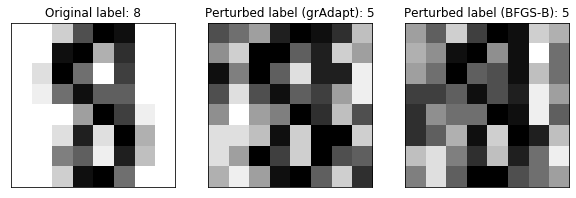

In [35]:
for i in range(n_images):
    plot_grAdapt_bfgs_original_perturbed(i, ress_grAdapt, ress_bfgs)

In [40]:
np.sum(x_grAdapt, axis=1)

array([221, 224, 280, 303, 271, 232, 282, 272, 283, 307, 286, 250, 294,
       279, 266, 251, 321, 262, 303, 276, 292, 259, 287, 293, 247, 260,
       316, 265, 303, 299, 245, 266, 313, 285, 262, 258, 305, 278, 304,
       274, 270, 267, 292, 279, 301, 260, 343, 292, 287, 305, 249, 289,
       242, 248, 316, 315, 231, 275, 271, 270, 297, 325, 298, 278, 276,
       268, 286, 237, 262, 273, 263, 293, 258, 312, 312, 295, 267, 325,
       276, 274, 240, 307, 289, 283, 309, 299, 271, 233, 329, 315, 233,
       275, 276, 326, 262, 270, 318, 260, 278, 250], dtype=object)